# Etude  préprocessing données Accidents Routiers


## [Standardisation des données](#scaling_data)

## [Entrainement de quelques modèles](#train_models)

## [Hyperparameter tuning by grid-search](#tuning_gridsearch)

## [Jeux de données déséquilibrés](#data_desequilibre)

## [Réduction de dimension](#reduction_dimension)

In [2]:
# Import des packages
import pandas as pd;
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import missingno as msno

In [3]:
from sklearn.compose import make_column_selector as selector

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

In [5]:
# numerical scaling numerical features which will be standardized
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

In [6]:
from sklearn.preprocessing import OrdinalEncoder

In [7]:
from sklearn import set_config

In [8]:
import time

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

!conda install -c conda-forge imbalanced-learn

In [11]:
from collections import Counter

In [12]:
from imblearn.under_sampling import RandomUnderSampler,  ClusterCentroids
from imblearn.metrics import classification_report_imbalanced, geometric_mean_score

In [13]:
from imblearn.over_sampling import RandomOverSampler, SMOTE

In [14]:
from sklearn.preprocessing import MinMaxScaler

In [15]:
from sklearn.linear_model import LogisticRegression

In [16]:
from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectFromModel, RFE, RFECV
from sklearn.feature_selection import SelectPercentile, chi2, f_classif, mutual_info_classif

In [17]:
from sklearn.neighbors import KNeighborsClassifier

In [18]:
from sklearn.linear_model import RidgeClassifier, SGDClassifier

In [19]:
from sklearn.tree import DecisionTreeClassifier

In [20]:
from sklearn.ensemble import AdaBoostClassifier

from imblearn.ensemble import EasyEnsembleClassifier, RUSBoostClassifier

In [21]:
from imblearn.ensemble import BalancedRandomForestClassifier

In [22]:
from sklearn.metrics import balanced_accuracy_score

In [23]:
from sklearn.ensemble import BaggingClassifier

from imblearn.ensemble import BalancedBaggingClassifier

In [24]:
# Importez la librairie tqdm
import tqdm

In [83]:
from itertools import cycle
from sklearn.metrics import average_precision_score, precision_recall_curve


In [84]:
from sklearn.model_selection import cross_validate

from sklearn.model_selection import GridSearchCV

In [25]:
# Using the categorical dtype is a great way to save memory and boost performance. Specifying the dtypes will lower the amount of memory required to load your dataset. This is quite helpful when dealing with large datasets!

# Create a dictionary with column names as keys and "category" as values
acc_dtypes = {
    "place":"category",
    "catu":"category",
    "grav":"category",
    "sexe":"category",
    "trajet":"category",
    "locp":"category",
    "actp":"category",
    "etatp":"category",
    "secuUn":"category",
    "secuDeux":"category",
    "tranches_ages":"category",
    "catr":"category",
    "circ":"category",
    "vosp":"category",
    "prof":"category",
    "plan":"category",
    "surf":"category",
    "infra":"category",
    "situ":"category",
    "senc":"category",
    "obs":"category",
    "obsm":"category",
    "choc":"category",
    "manv":"category",
    "catv_Label":"category",
    "lum":"category",
    "agg":"category",
    "int":"category",
    "atm":"category",
    "col":"category",
    "jour_de_la_semaine":"category",
    "heure":"category",
    }

In [26]:
# Read in the CSV using the dtypes parameter
accRoutierFr = pd.read_csv('fusion3.csv', parse_dates=["an_nais", "date"], dtype=acc_dtypes, low_memory=False)
accRoutierFr.head()

,Unnamed: 0,num_acc,place,catu,grav,sexe,trajet,locp,actp,etatp,...,lum,agg,int,atm,col,com,dep,date,jour_de_la_semaine,heure
0,0,200500000001,1.0,Conducteur,Blessé léger,Masculin,Domicile – travail,Sans objet,Non renseigné ou sans objet,Non renseigné,...,Nuit sans éclairage public,En agglomération,Hors intersection,Normale,Deux véhicules – par le coté,11,59,2005-01-12,Mercredi,19
1,1,200500000001,1.0,Conducteur,Blessé hospitalisé,Féminin,Courses – achats,Sans objet,Non renseigné ou sans objet,Non renseigné,...,Nuit sans éclairage public,En agglomération,Hors intersection,Normale,Deux véhicules – par le coté,11,59,2005-01-12,Mercredi,19
2,2,200500000001,2.0,Passager,Indemne,Masculin,Non renseigné,Sans objet,Non renseigné ou sans objet,Non renseigné,...,Nuit sans éclairage public,En agglomération,Hors intersection,Normale,Deux véhicules – par le coté,11,59,2005-01-12,Mercredi,19
3,3,200500000001,4.0,Passager,Indemne,Masculin,Non renseigné,Sans objet,Non renseigné ou sans objet,Non renseigné,...,Nuit sans éclairage public,En agglomération,Hors intersection,Normale,Deux véhicules – par le coté,11,59,2005-01-12,Mercredi,19
4,4,200500000001,5.0,Passager,Indemne,Masculin,Non renseigné,Sans objet,Non renseigné ou sans objet,Non renseigné,...,Nuit sans éclairage public,En agglomération,Hors intersection,Normale,Deux véhicules – par le coté,11,59,2005-01-12,Mercredi,19


In [27]:
accRoutierFr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2291797 entries, 0 to 2291796
Data columns (total 42 columns):
 #   Column              Dtype         
---  ------              -----         
 0   Unnamed: 0          int64         
 1   num_acc             int64         
 2   place               category      
 3   catu                category      
 4   grav                category      
 5   sexe                category      
 6   trajet              category      
 7   locp                category      
 8   actp                category      
 9   etatp               category      
 10  an_nais             datetime64[ns]
 11  num_veh             object        
 12  secuUn              category      
 13  secuDeux            category      
 14  age_acc_an          float64       
 15  tranches_ages       category      
 16  catr                category      
 17  circ                category      
 18  nbv                 float64       
 19  vosp                category      
 20  pr

In [28]:
accRoutierFr.grav.cat.categories

Index(['Blessé hospitalisé', 'Blessé léger', 'Indemne', 'Tué'], dtype='object')

In [29]:
accRoutierFr.grav = accRoutierFr.grav.cat.reorder_categories(
  new_categories=['Indemne', 'Blessé léger', 'Blessé hospitalisé', 'Tué'], 
  ordered=True
)

In [30]:
accRoutierFr.grav.cat.categories

Index(['Indemne', 'Blessé léger', 'Blessé hospitalisé', 'Tué'], dtype='object')

In [31]:
accRoutierFr.jour_de_la_semaine.cat.categories

Index(['Dimanche', 'Jeudi', 'Lundi', 'Mardi', 'Mercredi', 'Samedi',
       'Vendredi'],
      dtype='object')

In [32]:
accRoutierFr.jour_de_la_semaine = accRoutierFr.jour_de_la_semaine.cat.reorder_categories(
  new_categories=['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche'], 
  ordered=True
)

In [33]:
accRoutierFr.jour_de_la_semaine.cat.categories

Index(['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi',
       'Dimanche'],
      dtype='object')

In [34]:
accRoutierFr.heure.cat.categories

Index(['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19',
       '2', '20', '21', '22', '23', '3', '4', '5', '6', '7', '8', '9'],
      dtype='object')

In [35]:
accRoutierFr.heure = accRoutierFr.heure.cat.reorder_categories(
  new_categories=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', 
                  '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23'], 
  ordered=True
)

In [36]:
accRoutierFr.heure.cat.categories

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23'],
      dtype='object')

In [37]:
accRoutierFr.infra.cat.categories

Index(['Aucun', 'Autres', 'Bretelle d’échangeur ou de raccordement',
       'Carrefour aménagé', 'Chantier', 'Non renseigné', 'Pont - autopont',
       'Souterrain - tunnel', 'Voie ferrée', 'Zone de péage', 'Zone piétonne'],
      dtype='object')

In [38]:
accRoutierFr.vosp.cat.categories

Index(['Bande cyclable(2)', 'Non renseigné(-1)', 'Piste cyclable(1)',
       'Sans objet(0)', 'Voie réservée(3)'],
      dtype='object')

In [39]:
accRoutierFr.col.cat.categories

Index(['Autre collision', 'Deux véhicules - frontale',
       'Deux véhicules – par le coté', 'Deux véhicules – par l’arrière',
       'Non renseigné', 'Sans collision',
       'Trois véhicules et plus - collisions multiples',
       'Trois véhicules et plus – en chaîne'],
      dtype='object')

In [40]:
accRoutierFr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2291797 entries, 0 to 2291796
Data columns (total 42 columns):
 #   Column              Dtype         
---  ------              -----         
 0   Unnamed: 0          int64         
 1   num_acc             int64         
 2   place               category      
 3   catu                category      
 4   grav                category      
 5   sexe                category      
 6   trajet              category      
 7   locp                category      
 8   actp                category      
 9   etatp               category      
 10  an_nais             datetime64[ns]
 11  num_veh             object        
 12  secuUn              category      
 13  secuDeux            category      
 14  age_acc_an          float64       
 15  tranches_ages       category      
 16  catr                category      
 17  circ                category      
 18  nbv                 float64       
 19  vosp                category      
 20  pr

In [41]:
accRoutierFr.dep.unique()

array(['59', '62', '80', '20', '60', '76', '27', '35', '22', '29', '56',
       '14', '50', '61', '44', '49', '53', '72', '85', '33', '24', '40',
       '47', '64', '86', '16', '17', '79', '87', '19', '23', '31', '90',
       '12', '32', '46', '65', '81', '69', '82', '10', '70', '26', '38',
       '42', '73', '74', '63', '30', '15', '43', '57', '54', '55', '88',
       '67', '68', '51', '52', '21', '58', '71', '89', '25', '39', '13',
       '83', '84', '34', '11', '48', '66', '2A', '2B', '78', '91', '95',
       '77', '45', '18', '28', '36', '37', '41', '94', '75', '92', '93',
       '972', '971', '973', '974', '976', '988', '02', '09', '07', '04',
       '987', '03', '01', '06', '05', '986', '08', '977', '978', '975'],
      dtype=object)

In [42]:
len(accRoutierFr.com.unique())

14129

In [43]:
size = accRoutierFr.shape

# Count the number of missing values in each column
nan_values = accRoutierFr.isna().sum()

nan_values = nan_values.sort_values(ascending=True)*100/size[0]

nan_values

Unnamed: 0            0.000000
plan                  0.000000
surf                  0.000000
infra                 0.000000
situ                  0.000000
senc                  0.000000
occutc                0.000000
obs                   0.000000
obsm                  0.000000
choc                  0.000000
manv                  0.000000
agg                   0.000000
int                   0.000000
atm                   0.000000
dep                   0.000000
date                  0.000000
jour_de_la_semaine    0.000000
vosp                  0.000000
prof                  0.000000
circ                  0.000000
num_acc               0.000000
place                 0.000000
catu                  0.000000
grav                  0.000000
sexe                  0.000000
nbv                   0.000000
locp                  0.000000
actp                  0.000000
trajet                0.000000
an_nais               0.000000
num_veh               0.000000
secuUn                0.000000
secuDeux

In [44]:
# Removes the rows that contains NULL values.
accRoutierFr.dropna(inplace=True)

In [45]:
size = accRoutierFr.shape

# Count the number of missing values in each column
nan_values = accRoutierFr.isna().sum()

nan_values = nan_values.sort_values(ascending=True)*100/size[0]

nan_values

Unnamed: 0            0.0
infra                 0.0
situ                  0.0
senc                  0.0
occutc                0.0
obs                   0.0
obsm                  0.0
choc                  0.0
manv                  0.0
catv_Label            0.0
lum                   0.0
agg                   0.0
int                   0.0
atm                   0.0
col                   0.0
com                   0.0
dep                   0.0
date                  0.0
surf                  0.0
plan                  0.0
prof                  0.0
vosp                  0.0
num_acc               0.0
place                 0.0
catu                  0.0
grav                  0.0
sexe                  0.0
trajet                0.0
locp                  0.0
actp                  0.0
jour_de_la_semaine    0.0
etatp                 0.0
num_veh               0.0
secuUn                0.0
secuDeux              0.0
age_acc_an            0.0
tranches_ages         0.0
catr                  0.0
circ        

Les colonnes 'Unnamed: 0', 'num_acc' et 'num_veh' sont sans importance pour notre problème, et on aimerait pouvoir effectuer des prédictions sur la gravité des accidents peu importe la date et l'emplacement géographique de l'accident, on peut donc également s'affranchir de la colonne 'com', 'dep' et 'num_veh'.

##### Distribution en pourcentage de la variable cible.

In [46]:
target_name = "grav"
y = accRoutierFr[target_name]

In [47]:
y.value_counts(normalize=True)*100

Indemne               40.918403
Blessé léger          36.011343
Blessé hospitalisé    20.400796
Tué                    2.669458
Name: grav, dtype: float64

##### Pre-processing pour standardiser les features

In [48]:
categorical_columns_selector = selector(dtype_include="category")
categorical_columns = categorical_columns_selector(accRoutierFr.drop(["grav"], axis=1))
categorical_columns

['place',
 'catu',
 'sexe',
 'trajet',
 'locp',
 'actp',
 'etatp',
 'secuUn',
 'secuDeux',
 'tranches_ages',
 'catr',
 'circ',
 'vosp',
 'prof',
 'plan',
 'surf',
 'infra',
 'situ',
 'senc',
 'obs',
 'obsm',
 'choc',
 'manv',
 'catv_Label',
 'lum',
 'agg',
 'int',
 'atm',
 'col',
 'jour_de_la_semaine',
 'heure']

In [49]:
# Select columns based on their data type
# we use the utility make_column_selector to select only columns with a specific data type
numerical_columns_selector = selector(dtype_include=np.number)

numerical_columns = numerical_columns_selector(accRoutierFr.drop(["Unnamed: 0", "num_acc"], axis=1))
numerical_columns

['age_acc_an', 'nbv', 'occutc']

In [50]:
data_categorical = accRoutierFr[categorical_columns]
data_numerical = accRoutierFr[numerical_columns]

X = accRoutierFr[categorical_columns + numerical_columns]

In [51]:
X.head()

,place,catu,sexe,trajet,locp,actp,etatp,secuUn,secuDeux,tranches_ages,...,lum,agg,int,atm,col,jour_de_la_semaine,heure,age_acc_an,nbv,occutc
0,1.0,Conducteur,Masculin,Domicile – travail,Sans objet,Non renseigné ou sans objet,Non renseigné,Ceinture,Ceinture,23-31,...,Nuit sans éclairage public,En agglomération,Hors intersection,Normale,Deux véhicules – par le coté,Mercredi,19,29.021918,2.0,0.0
1,1.0,Conducteur,Féminin,Courses – achats,Sans objet,Non renseigné ou sans objet,Non renseigné,Ceinture,Ceinture,32-40,...,Nuit sans éclairage public,En agglomération,Hors intersection,Normale,Deux véhicules – par le coté,Mercredi,19,37.027397,2.0,0.0
2,2.0,Passager,Masculin,Non renseigné,Sans objet,Non renseigné ou sans objet,Non renseigné,Ceinture,Ceinture,41-50,...,Nuit sans éclairage public,En agglomération,Hors intersection,Normale,Deux véhicules – par le coté,Mercredi,19,41.030137,2.0,0.0
3,4.0,Passager,Masculin,Non renseigné,Sans objet,Non renseigné ou sans objet,Non renseigné,Dispositif enfants,Ceinture,0-11,...,Nuit sans éclairage public,En agglomération,Hors intersection,Normale,Deux véhicules – par le coté,Mercredi,19,1.002740,2.0,0.0
4,5.0,Passager,Masculin,Non renseigné,Sans objet,Non renseigné ou sans objet,Non renseigné,Ceinture,Ceinture,0-11,...,Nuit sans éclairage public,En agglomération,Hors intersection,Normale,Deux véhicules – par le coté,Mercredi,19,7.005479,2.0,0.0


In [52]:
print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")
print(f"Number of categorical features: {len(categorical_columns)}")
print(f"Number of numerical features: {len(numerical_columns)}")

Number of samples: 2291739
Number of features: 34
Number of categorical features: 31
Number of numerical features: 3


In [53]:
categorical_indexes=[]
for col in X.columns:
    if X[col].dtype == 'category':
        categorical_indexes.append(X.columns.get_loc(col))

In [54]:
X.dtypes

place                 category
catu                  category
sexe                  category
trajet                category
locp                  category
actp                  category
etatp                 category
secuUn                category
secuDeux              category
tranches_ages         category
catr                  category
circ                  category
vosp                  category
prof                  category
plan                  category
surf                  category
infra                 category
situ                  category
senc                  category
obs                   category
obsm                  category
choc                  category
manv                  category
catv_Label            category
lum                   category
agg                   category
int                   category
atm                   category
col                   category
jour_de_la_semaine    category
heure                 category
age_acc_an             float64
nbv     

In [55]:
categorical_indexes

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30]

In [56]:
data_numerical.head()

,age_acc_an,nbv,occutc
0,29.021918,2.0,0.0
1,37.027397,2.0,0.0
2,41.030137,2.0,0.0
3,1.002740,2.0,0.0
4,7.005479,2.0,0.0


In [57]:
# printing some statistics about the training data.
data_numerical.describe()

,age_acc_an,nbv,occutc
count,2.291739e+06,2.291739e+06,2.291739e+06
mean,3.755248e+01,2.133406e+00,1.529851e-01
std,1.812063e+01,1.525731e+00,3.282505e+00
min,1.000000e+00,-1.000000e+00,0.000000e+00
25%,2.301644e+01,2.000000e+00,0.000000e+00
50%,3.402466e+01,2.000000e+00,0.000000e+00
75%,5.003288e+01,2.000000e+00,0.000000e+00
max,9.006301e+01,9.900000e+01,9.000000e+02


We see that the dataset's features span across different ranges. 

Tip

Here are some reasons for scaling features:

Models that rely on the distance between a pair of samples, for instance k-nearest neighbors, should be trained on normalized features to make each feature contribute approximately equally to the distance computations.
Many models such as logistic regression use a numerical solver (based on gradient descent) to find their optimal parameters. This solver converges faster when the features are scaled.

Whether or not a machine learning model requires scaling the features depends on the model family. Linear models such as logistic regression generally benefit from scaling the features while other models such as decision trees do not need such preprocessing (but will not suffer from it).

Le paramètre shuffle permet de décider si les échantillons sont choisis aléatoirement (option par défaut), ou bien si la séparation doit se faire en respectant l'ordre des données indiquées. Ce dernier cas peut correspondre à des cas d'usage où la donnée traitée admet un ordre ou une dimension temporelle comme un cours financiers, parcours d'un utilisateur sur un site, etc..

In [58]:
# split the array of features values, X, and target values, y, into training and test sets, 
#   ensuring that the same label proportions are reflected after the split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=259)



In [59]:
print(f"Number of samples in testing: {X_test.shape[0]} => "
      f"{X_test.shape[0] / data_categorical.shape[0] * 100:.1f}% of the"
      f" original set")

print(f"Number of samples in training: {X_train.shape[0]} => "
      f"{X_train.shape[0] / data_categorical.shape[0] * 100:.1f}% of the"
      f" original set")

Number of samples in testing: 458348 => 20.0% of the original set
Number of samples in training: 1833391 => 80.0% of the original set


## Histogram-based Gradient Boosting Classification

###### Model Training

Histogram-based Gradient Boosting Classification Tree is much faster than GradientBoostingClassifier for big datasets (n_samples >= 10 000).

In [60]:
###### Standardisation
numerical_preprocessor = StandardScaler()

In [61]:
# Modèle : Histogram-based Gradient Boosting Classification Tree
hist_gradient_boosting = HistGradientBoostingClassifier(random_state=52)   

###### Gradient boosting estimator with dropped categorical features

In [60]:
# create an estimator where the categorical features are dropped
dropper_categorical_preprocessor = make_column_transformer(
    ("drop", make_column_selector(dtype_include="category")), remainder="passthrough"
)

dropper_preprocessor = ColumnTransformer([
    ('dropper', dropper_categorical_preprocessor, categorical_columns),
    ('standard_scaler', numerical_preprocessor, numerical_columns)])

#  create our dropped model
#hist_dropped = make_pipeline(
#    dropper_preprocessor, HistGradientBoostingClassifier() #random_state=42)
#)
hist_dropped = Pipeline(steps=[
    ('scaler', dropper_preprocessor), 
    ('model_hist_dropped', hist_gradient_boosting) 
])

In [61]:
set_config(display='diagram')
hist_dropped

Pipeline(steps=[('scaler',
                 ColumnTransformer(transformers=[('dropper',
                                                  ColumnTransformer(remainder='passthrough',
                                                                    transformers=[('drop',
                                                                                   'drop',
                                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x7fd4fe5358e0>)]),
                                                  ['place', 'catu', 'sexe',
                                                   'trajet', 'locp', 'actp',
                                                   'etatp', 'secuUn',
                                                   'secuDeux', 'tranches_ages',
                                                   'catr', 'circ', 'vosp',
                                                   'prof', 'plan', 'surf',
                                                   'infra', 'situ', 'senc',
                                                   'obs', 'obsm', 'choc',
                                                   'manv', 'catv_Label', 'lum',
                                                   'agg', 'int', 'atm', 'col',
                                                   'jour_de_la_semaine', ...]),
                                                 ('standard_scaler',
                                                  StandardScaler(),
                                                  ['age_acc_an', 'nbv',
                                                   'occutc'])])),
                ('model_hist_dropped',
                 HistGradientBoostingClassifier(random_state=52))])

###### Gradient boosting estimator with one-hot encoding

In [62]:
one_hot_categorical_preprocessor = OneHotEncoder(sparse=False, 
                                                 handle_unknown="ignore")# to solve the potential issues due to rare categories

one_hot_preprocessor = ColumnTransformer([
    ('one_hot_encoder', one_hot_categorical_preprocessor, categorical_columns),
    ('standard_scaler', numerical_preprocessor, numerical_columns)])

#  create our model
hist_one_hot = Pipeline(steps=[
    ('one_hot_preprocessor', one_hot_preprocessor), 
    ('model_hist_one_hot', hist_gradient_boosting)
])

In [63]:
set_config(display='diagram')
hist_one_hot

Pipeline(steps=[('one_hot_preprocessor',
                 ColumnTransformer(transformers=[('one_hot_encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['place', 'catu', 'sexe',
                                                   'trajet', 'locp', 'actp',
                                                   'etatp', 'secuUn',
                                                   'secuDeux', 'tranches_ages',
                                                   'catr', 'circ', 'vosp',
                                                   'prof', 'plan', 'surf',
                                                   'infra', 'situ', 'senc',
                                                   'obs', 'obsm', 'choc',
                                                   'manv', 'catv_Label', 'lum',
                                                   'agg', 'int', 'atm', 'col',
                                                   'jour_de_la_semaine', ...]),
                                                 ('standard_scaler',
                                                  StandardScaler(),
                                                  ['age_acc_an', 'nbv',
                                                   'occutc'])])),
                ('model_hist_one_hot',
                 HistGradientBoostingClassifier(random_state=52))])

###### Gradient boosting estimator with ordinal encoding

In [64]:
# pipeline that will treat categorical features as if they were ordered quantities
# create the transformer and associate each of these preprocessors with their respective columns.
ordinal_categorical_preprocessor = make_column_transformer(
    (
        OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan),
        make_column_selector(dtype_include="category"),
    ),
    remainder="passthrough",
    # Use short feature names to make it easier to specify the categorical
    # variables in the HistGradientBoostingRegressor in the next step
    # of the pipeline.
    verbose_feature_names_out=False,
)

#hist_ordinal = make_pipeline(
#    ordinal_encoder, HistGradientBoostingClassifier() #(random_state=42)
#)

# create the transformer and associate each of these preprocessors with their respective columns.
#categorical_preprocessor = OrdinalEncoder(handle_unknown="use_encoded_value",  unknown_value=-1)

ordinal_preprocessor = ColumnTransformer([
    ('ordinal_encoder', ordinal_categorical_preprocessor, categorical_columns),
    ('standard_scaler', numerical_preprocessor, numerical_columns)])

#  create our model
hist_ordinal = Pipeline(steps=[
    ('ordinal_preprocessor', ordinal_preprocessor), 
    ('model_hist_ordinal', hist_gradient_boosting)
])

In [65]:
set_config(display='diagram')
hist_ordinal

Pipeline(steps=[('ordinal_preprocessor',
                 ColumnTransformer(transformers=[('ordinal_encoder',
                                                  ColumnTransformer(remainder='passthrough',
                                                                    transformers=[('ordinalencoder',
                                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                  unknown_value=nan),
                                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x7fd4fe540250>)],
                                                                    verbose_feature_names_out=False),...
                                                   'trajet', 'locp', 'actp',
                                                   'etatp', 'secuUn',
                                                   'secuDeux', 'tranches_ages',
                                                   'catr', 'circ', 'vosp',
                                                   'prof', 'plan', 'surf',
                                                   'infra', 'situ', 'senc',
                                                   'obs', 'obsm', 'choc',
                                                   'manv', 'catv_Label', 'lum',
                                                   'agg', 'int', 'atm', 'col',
                                                   'jour_de_la_semaine', ...]),
                                                 ('standard_scaler',
                                                  StandardScaler(),
                                                  ['age_acc_an', 'nbv',
                                                   'occutc'])])),
                ('model_hist_ordinal',
                 HistGradientBoostingClassifier(random_state=52))])

###### Gradient boosting estimator with native categorical support
The HistGradientBoostingClassifier estimator that will natively handle categorical features. This estimator will not treat categorical features as ordered quantities.

Since the HistGradientBoostingClassifier requires category values to be encoded in [0, n_unique_categories - 1], we still rely on an OrdinalEncoder to pre-process the data

In [88]:
categorical_preprocessor = OrdinalEncoder(handle_unknown="use_encoded_value",
                                          unknown_value=-1)

preprocessor = ColumnTransformer([
    ('ordinal_encoder', categorical_preprocessor, categorical_columns),
    ('standard_scaler', numerical_preprocessor, numerical_columns)])
#  create our model
hist_native_ordinal = Pipeline(steps=[
    ('standard_scaler_preprocessor', preprocessor), 
    ('model_hist_native_ordinal', hist_gradient_boosting)
])

In [89]:
set_config(display='diagram')
hist_native_ordinal

Pipeline(steps=[('standard_scaler_preprocessor',
                 ColumnTransformer(transformers=[('ordinal_encoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['place', 'catu', 'sexe',
                                                   'trajet', 'locp', 'actp',
                                                   'etatp', 'secuUn',
                                                   'secuDeux', 'tranches_ages',
                                                   'catr', 'circ', 'vosp',
                                                   'prof', 'plan', 'surf',
                                                   'infra', 'situ', 'senc',
                                                   'obs', 'obsm', 'choc',
                                                   'manv', 'catv_Label', 'lum',
                                                   'agg', 'int', 'atm', 'col',
                                                   'jour_de_la_semaine', ...]),
                                                 ('standard_scaler',
                                                  StandardScaler(),
                                                  ['age_acc_an', 'nbv',
                                                   'occutc'])])),
                ('model_hist_native_ordinal',
                 HistGradientBoostingClassifier(random_state=52))])

In [68]:
preprocessor = ColumnTransformer([
    ('one_hot_encoder', one_hot_categorical_preprocessor, categorical_columns),
    ('standard_scaler', numerical_preprocessor, numerical_columns)])
#  create our model
hist_native_hot = Pipeline(steps=[
    ('standard_scaler_preprocessor', preprocessor), 
    ('model_hist_native_One_hot', hist_gradient_boosting)
])

In [69]:
set_config(display='diagram')
hist_native_hot

Pipeline(steps=[('standard_scaler_preprocessor',
                 ColumnTransformer(transformers=[('one_hot_encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['place', 'catu', 'sexe',
                                                   'trajet', 'locp', 'actp',
                                                   'etatp', 'secuUn',
                                                   'secuDeux', 'tranches_ages',
                                                   'catr', 'circ', 'vosp',
                                                   'prof', 'plan', 'surf',
                                                   'infra', 'situ', 'senc',
                                                   'obs', 'obsm', 'choc',
                                                   'manv', 'catv_Label', 'lum',
                                                   'agg', 'int', 'atm', 'col',
                                                   'jour_de_la_semaine', ...]),
                                                 ('standard_scaler',
                                                  StandardScaler(),
                                                  ['age_acc_an', 'nbv',
                                                   'occutc'])])),
                ('model_hist_native_One_hot',
                 HistGradientBoostingClassifier(random_state=52))])

In [70]:
preprocessor = ColumnTransformer([
    ('ordinal_encoder', OrdinalEncoder(), ['jour_de_la_semaine', 'heure']),
    ('one_hot_encoder', one_hot_categorical_preprocessor, ['place', 'catu', 'sexe', 'trajet', 'locp', 'actp', 'etatp',
       'secuUn', 'secuDeux', 'tranches_ages', 'catr', 'circ', 'vosp', 'prof', 'plan', 'surf', 'infra', 
        'situ', 'senc', 'obs', 'obsm', 'choc', 'manv', 'catv_Label', 'lum', 'agg', 'int', 'atm', 'col']),
    ('standard_scaler', numerical_preprocessor, numerical_columns)])
#  create our model
hist_native = Pipeline(steps=[
    ('standard_scaler_preprocessor', preprocessor), 
    ('model_hist_native',  hist_gradient_boosting)
     #HistGradientBoostingClassifier(random_state=52,
        #categorical_features=np.array(column_mask),
])

In [71]:
set_config(display='diagram')
hist_native

Pipeline(steps=[('standard_scaler_preprocessor',
                 ColumnTransformer(transformers=[('ordinal_encoder',
                                                  OrdinalEncoder(),
                                                  ['jour_de_la_semaine',
                                                   'heure']),
                                                 ('one_hot_encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['place', 'catu', 'sexe',
                                                   'trajet', 'locp', 'actp',
                                                   'etatp', 'secuUn',
                                                   'secuDeux', 'tranches_ages',
                                                   'catr', 'circ', 'vosp',
                                                   'prof', 'plan', 'surf',
                                                   'infra', 'situ', 'senc',
                                                   'obs', 'obsm', 'choc',
                                                   'manv', 'catv_Label', 'lum',
                                                   'agg', 'int', 'atm',
                                                   'col']),
                                                 ('standard_scaler',
                                                  StandardScaler(),
                                                  ['age_acc_an', 'nbv',
                                                   'occutc'])])),
                ('model_hist_native',
                 HistGradientBoostingClassifier(random_state=52))])

###### Histogram-based Gradient Boosting Classification Models comparison

We evaluate the models using cross validation. Here we compare the models performance in terms of accuracy and fit times.

Create RocCurveDisplay & Create PrecisionRecallDisplay
https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_display_object_visualization.html#create-confusionmatrixdisplay

 - La matrice de confusion : 
     chaque colonne de la matrice représente le nombre d'occurrences d'une classe estimée, tandis que chaque ligne représente le nombre d'occurrences d'une classe réelle.

In [72]:
# the models list contains instances of different classifier models. 
# The loop iterates through each model, trains it, makes predictions, 
#  calculates evaluation metrics, and then prints the metrics for each model.

# Define a list of classifier models
models = [
    hist_dropped,
    hist_one_hot,
    hist_ordinal,
    hist_native_ordinal,
    hist_native_hot,
    hist_native
]

model_names=[]
execution_times=[]
test_times=[]
train_scores=[]
test_scores=[]
accuracy_scores=[]
mean_auc_score=[]


#seed for random state and splits - number of Kfolds
random_seed = 2
splits = 5
#Scikit Kfold model call
kfold = KFold(n_splits=splits, random_state=random_seed, shuffle=True)



# Iterate through the models and evaluate each
for model in models:
    step_names = list(model.named_steps.keys())
    model_name = step_names[-1]
    model_names.append(model_name)
    
    start_time = time.time()

    # Train the classifier model
    model.fit(X_train, y_train)

    end_time = time.time()
    execution_time = end_time - start_time
    execution_times.append(execution_time)

    # Taux de bonnes prédictions du modèle de classification sur l'ensemble de test
    test_scores.append(model.score(X_test, y_test))
    train_scores.append(model.score(X_train, y_train))
    
    # Make predictions
    start_time = time.time()
    y_pred = model.predict(X_test)
    end_time = time.time()
    test_time = end_time - start_time
    test_times.append(test_time)
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    #precision = precision_score(y_test, y_pred)
    #    ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].
    #recall = recall_score(y_test, y_pred)
    #f1 = f1_score(y_test, y_pred)
    
    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Print the evaluation metrics for the current model
    print(f"Model: {model_name}")
    print("-" * 75)
    #print(f"Execution time: {execution_time:.4f} seconds")
    #print("Accuracy:", accuracy)
    #print("Precision:", precision)
    #print("Recall:", recall)
    #print("F1-score:", f1)
    # Print classification report
    print("Classification Report :")
    print(classification_report(y_test, y_pred))
    # Print confusion matrix
    print("Confusion Matrix:")
    print(conf_matrix)
    
    #results set equal to model with kfolds
    #scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='roc_auc')
    #print("Mean AUC Score : ", scores.mean())
    #mean_auc_score.append(scores.mean())
    #printing the averaged score over the 5 Kfolds
    #print("Accuracy(averaged score over the 5 Kfolds): %.3f%% (%.3f%%)" % (scores.mean()*100.0, scores.std()*100.0))
    
    print("=" * 75)

Model: model_hist_dropped
---------------------------------------------------------------------------
Classification Report :
                    precision    recall  f1-score   support

Blessé hospitalisé       0.38      0.04      0.07     93507
      Blessé léger       0.46      0.27      0.34    165057
           Indemne       0.45      0.84      0.58    187549
               Tué       0.78      0.00      0.00     12235

          accuracy                           0.45    458348
         macro avg       0.52      0.29      0.25    458348
      weighted avg       0.45      0.45      0.37    458348

Confusion Matrix:
[[  3666  21865  67974      2]
 [  2870  43993 118194      0]
 [  2426  27839 157284      0]
 [   720   1967   9541      7]]
Model: model_hist_one_hot
---------------------------------------------------------------------------
Classification Report :
                    precision    recall  f1-score   support

Blessé hospitalisé       0.54      0.44      0.48     93507
 

In [73]:
# Calling DataFrame constructor after zipping
# both lists, with columns specified
hist_gradient_boosting_results = pd.DataFrame(
    list(zip(model_names, execution_times, test_times, train_scores, test_scores, accuracy_scores)),
                  columns =['Model Name', 'Execution time', 'Test time', 'Train Accuracy', 'Test score', 'Test Accuracy']
                 )

# Exporting the RESULT DataFrame into a CSV file
hist_gradient_boosting_results.to_csv('Acc_Results_hist_gradient_boosting.csv')
# Printing
hist_gradient_boosting_results

,Model Name,Execution time,Test time,Train Accuracy,Test score,Test Accuracy
0,model_hist_dropped,34.914586,1.479341,0.448570,0.447149,0.447149
1,model_hist_one_hot,1208.417817,14.446718,0.660673,0.659527,0.659527
2,model_hist_ordinal,2124.801684,6.154147,0.660570,0.659331,0.659331
3,model_hist_native_ordinal,118.096088,6.168384,0.660570,0.659331,0.659331
4,model_hist_native_One_hot,3853.702844,20.419032,0.660673,0.659527,0.659527
5,model_hist_native,5496.046752,17.605063,0.660830,0.659453,0.659453


In [74]:
print("Accuracy: %.3f%% (%.3f%%)" % (accuracy_scores[0]*100.0, accuracy_scores[0]*100.0))

Accuracy: 44.715% (44.715%)


In [75]:
(hist_gradient_boosting_results[['Train Accuracy', 'Test score', 'Test Accuracy']]*100).round(3)

,Train Accuracy,Test score,Test Accuracy
0,44.857,44.715,44.715
1,66.067,65.953,65.953
2,66.057,65.933,65.933
3,66.057,65.933,65.933
4,66.067,65.953,65.953
5,66.083,65.945,65.945


For datasets with categorical features, using the native categorical support is often better than relying on one-hot encoding (OneHotEncoder), because one-hot encoding requires more tree depth to achieve equivalent splits. It is also usually better to rely on the native categorical support rather than to treat categorical features as continuous (ordinal), which happens for ordinal-encoded categorical data, since categories are nominal quantities where order does not matter.



##### Plot accuracy, training and test time of each histo gradient boosting classifier

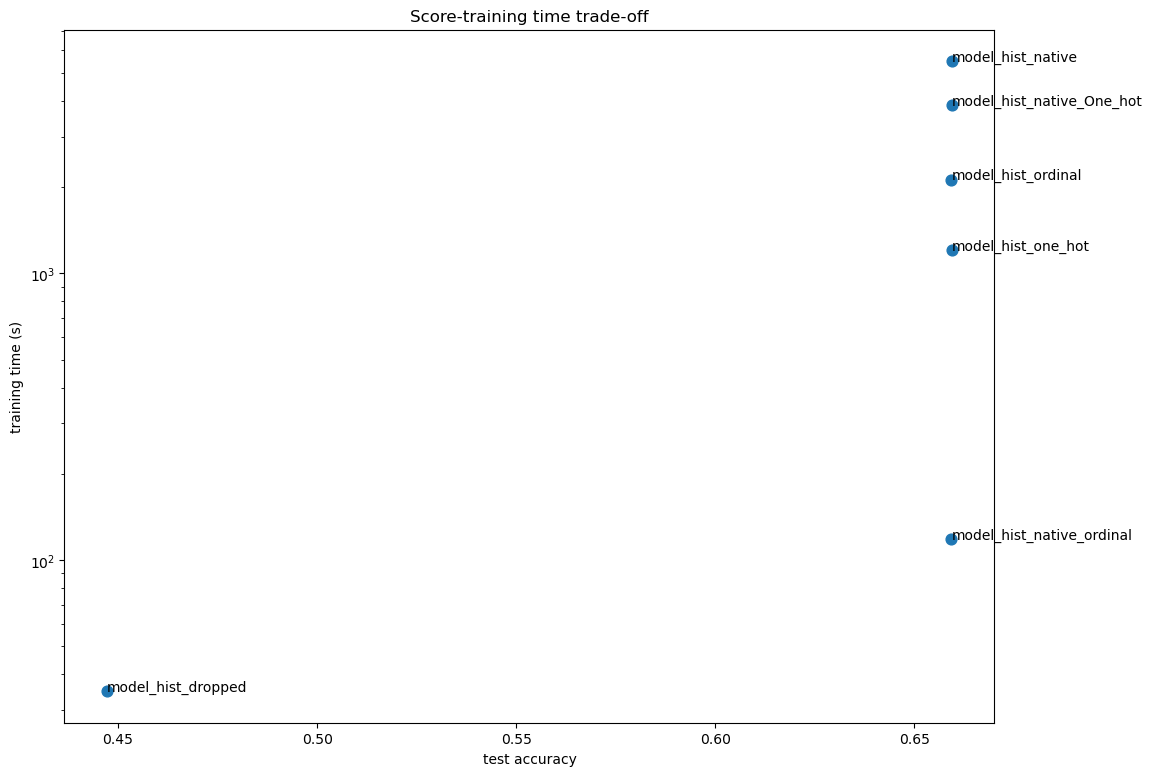

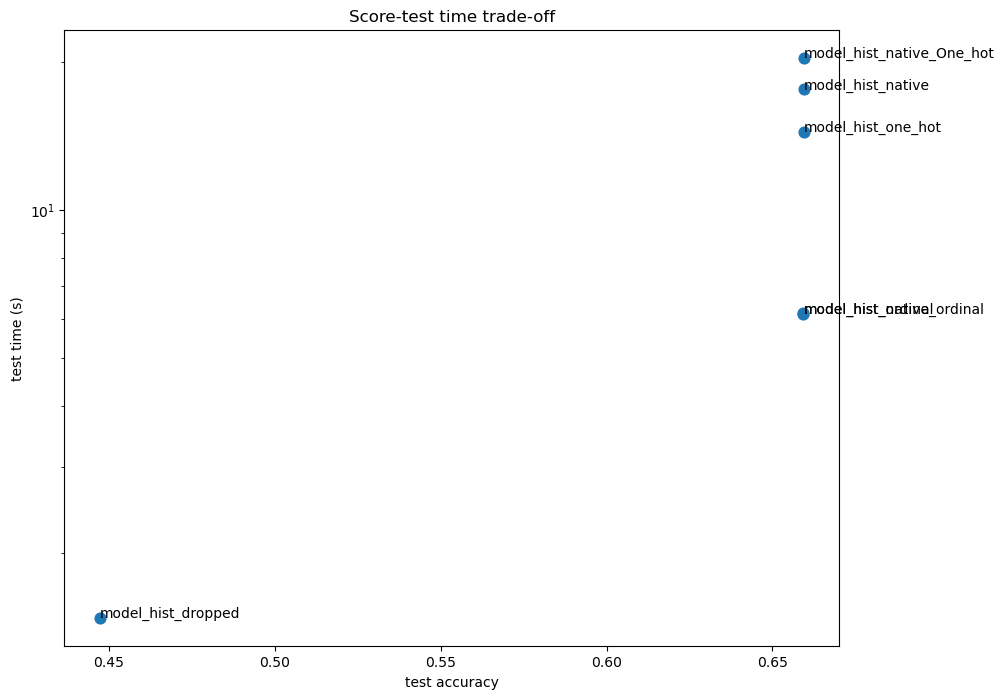

In [76]:

fig, ax1 = plt.subplots(figsize=(12, 9))
ax1.scatter(test_scores, execution_times, s=60)
ax1.set(
    title="Score-training time trade-off",
    yscale="log",
    xlabel="test accuracy",
    ylabel="training time (s)",
)
fig, ax2 = plt.subplots(figsize=(10, 8))
ax2.scatter(test_scores, test_times, s=60)
ax2.set(
    title="Score-test time trade-off",
    yscale="log",
    xlabel="test accuracy",
    ylabel="test time (s)",
)

for i, txt in enumerate(model_names):
    ax1.annotate(txt, (test_scores[i], execution_times[i]))
    ax2.annotate(txt, (test_scores[i], test_times[i]))

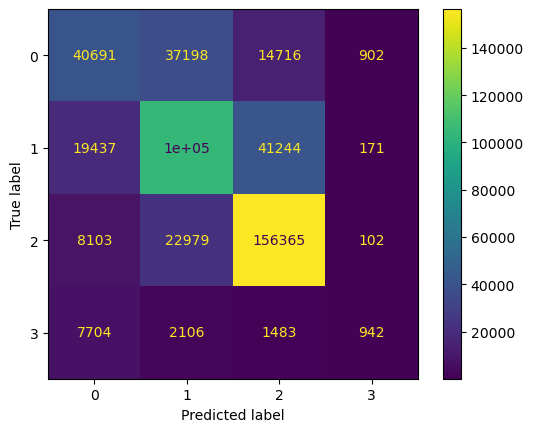

In [77]:
#X_test_norm = hist_ordinal.transform(X_test)
hist_ordinal.fit(X_train, y_train)
y_pred = hist_ordinal.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

In [78]:
# Affichage de la matrice de confusion obtenue grâce aux prédictions sur l'ensemble de test.
#y_pred = hist_native_hot.predict(X_test)
print(pd.crosstab(y_test, y_pred))
print("=" * 50)

# Affichage du rapport de résultat sur l'ensemble de test obtenu par classification_report_imbalanced
print("Classification Report imbalanced :")
print(classification_report_imbalanced(y_test, y_pred))

col_0               Blessé hospitalisé  Blessé léger  Indemne  Tué
grav                                                              
Indemne                           8103         22979   156365  102
Blessé léger                     19437        104205    41244  171
Blessé hospitalisé               40691         37198    14716  902
Tué                               7704          2106     1483  942
Classification Report imbalanced :
                          pre       rec       spe        f1       geo       iba       sup

Blessé hospitalisé       0.54      0.44      0.90      0.48      0.63      0.37     93507
      Blessé léger       0.63      0.63      0.79      0.63      0.71      0.49    165057
           Indemne       0.73      0.83      0.79      0.78      0.81      0.66    187549
               Tué       0.44      0.08      1.00      0.13      0.28      0.07     12235

       avg / total       0.65      0.66      0.82      0.65      0.72      0.52    458348



Le tableau de rapport de classification montre que le rappel et le f1-score de la classe 'Blessé hospitalisé' et de la classe 'Tué' sont mauvais, tandis que pour les classe 'Blessé léger' et 'Indemne', ils sont élevés.
En outre, la moyenne géométrique est également faible uniquement pour la classe 'Tué'. 
Le modèle semble ne pas être acceptable ainsi pour notre problème.

In [79]:
print(sorted(Counter(y_train).items()))

[('Blessé hospitalisé', 374026), ('Blessé léger', 660229), ('Indemne', 750194), ('Tué', 48942)]


## Scaling data
<div class="alert alert-block alert-info">
<h2><a id = "scaling_data">Standardisation des données</a></h2>
</div>

##### Strategies to encode categories

In [62]:
X["jour_de_la_semaine"].cat.categories

Index(['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi',
       'Dimanche'],
      dtype='object')

In [63]:
X["heure"].cat.categories

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23'],
      dtype='object')

In [64]:
# Encoding ordinal categorie
heure_jsemaine_column = X[["jour_de_la_semaine", "heure"]]

encoder = OrdinalEncoder()
heure_jsemaine_encoded = encoder.fit_transform(heure_jsemaine_column)
heure_jsemaine_encoded

array([[ 4., 11.],
       [ 4., 11.],
       [ 4., 11.],
       ...,
       [ 5.,  3.],
       [ 4.,  9.],
       [ 4.,  9.]])

In [65]:
# check the mapping between the categories and the numerical values
encoder.categories_

[array(['Dimanche', 'Jeudi', 'Lundi', 'Mardi', 'Mercredi', 'Samedi',
        'Vendredi'], dtype=object),
 array(['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18',
        '19', '2', '20', '21', '22', '23', '3', '4', '5', '6', '7', '8',
        '9'], dtype=object)]

In [66]:
print(
    f"The dataset encoded contains {heure_jsemaine_encoded.shape[1]} features")

The dataset encoded contains 2 features


In [67]:
cat_ordered_encoded = pd.DataFrame(heure_jsemaine_encoded, columns =['jour_de_la_semaine', 'heure'])
cat_ordered_encoded.head()

,jour_de_la_semaine,heure
0,4.0,11.0
1,4.0,11.0
2,4.0,11.0
3,4.0,11.0
4,4.0,11.0


In [68]:
# Encoding nominal categories (without assuming any order)
oneHotEncoder = OneHotEncoder(sparse=False)

categorical_columns.remove("jour_de_la_semaine")
categorical_columns.remove("heure")

X_categorical_encoded = oneHotEncoder.fit_transform(X[categorical_columns])


print(f"The encoded dataset contains {X_categorical_encoded.shape[1]} features")

The encoded dataset contains 261 features


In [69]:
# dataframe with informative column names as provided by the encoder object:
columns_encoded = oneHotEncoder.get_feature_names_out(categorical_columns)
cat_data_encoded= pd.DataFrame(X_categorical_encoded, columns=columns_encoded)
cat_data_encoded.head()

,place_0.0,place_1.0,place_10.0,place_2.0,place_3.0,place_4.0,place_5.0,place_6.0,place_7.0,place_8.0,...,atm_Temps éblouissant,atm_Vent fort - tempête,col_Autre collision,col_Deux véhicules - frontale,col_Deux véhicules – par le coté,col_Deux véhicules – par l’arrière,col_Non renseigné,col_Sans collision,col_Trois véhicules et plus - collisions multiples,col_Trois véhicules et plus – en chaîne
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [70]:
print(cat_data_encoded.columns)

Index(['place_0.0', 'place_1.0', 'place_10.0', 'place_2.0', 'place_3.0',
       'place_4.0', 'place_5.0', 'place_6.0', 'place_7.0', 'place_8.0',
       ...
       'atm_Temps éblouissant', 'atm_Vent fort - tempête',
       'col_Autre collision', 'col_Deux véhicules - frontale',
       'col_Deux véhicules – par le coté',
       'col_Deux véhicules – par l’arrière', 'col_Non renseigné',
       'col_Sans collision',
       'col_Trois véhicules et plus - collisions multiples',
       'col_Trois véhicules et plus – en chaîne'],
      dtype='object', length=261)


In [71]:
X.columns

Index(['place', 'catu', 'sexe', 'trajet', 'locp', 'actp', 'etatp', 'secuUn',
       'secuDeux', 'tranches_ages', 'catr', 'circ', 'vosp', 'prof', 'plan',
       'surf', 'infra', 'situ', 'senc', 'obs', 'obsm', 'choc', 'manv',
       'catv_Label', 'lum', 'agg', 'int', 'atm', 'col', 'jour_de_la_semaine',
       'heure', 'age_acc_an', 'nbv', 'occutc'],
      dtype='object')

In [72]:
# mise à jour de la liste des variables catégorielles
categorical_columns_selector = selector(dtype_include="category")
categorical_columns = categorical_columns_selector(accRoutierFr.drop(["grav"], axis=1))

##### scaling numerical variables

In [73]:
# Application de la standardisation des variables continues 
numerical_X_scaled = numerical_preprocessor.fit_transform(X[['age_acc_an', 'nbv', 'occutc']])
numerical_X_scaled

array([[-0.47076531, -0.08743727, -0.04660622],
       [-0.02897708, -0.08743727, -0.04660622],
       [ 0.19191704, -0.08743727, -0.04660622],
       ...,
       [-0.85751901, -0.08743727, -0.04660622],
       [ 0.85444819, -0.08743727, -0.04660622],
       [ 1.0753423 , -0.08743727, -0.04660622]])

In [74]:
data_numerical_scaled = pd.DataFrame(numerical_X_scaled,
                                 columns=['age_acc_an', 'nbv', 'occutc'])
data_numerical_scaled.describe()

,age_acc_an,nbv,occutc
count,2.291739e+06,2.291739e+06,2.291739e+06
mean,-1.438289e-13,1.813049e-13,-5.017623e-15
std,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.017175e+00,-2.053709e+00,-4.660622e-02
25%,-8.021821e-01,-8.743727e-02,-4.660622e-02
50%,-1.946855e-01,-8.743727e-02,-4.660622e-02
75%,6.887398e-01,-8.743727e-02,-4.660622e-02
max,2.897832e+00,6.348868e+01,2.741343e+02


In [75]:
data_numerical_scaled.columns

Index(['age_acc_an', 'nbv', 'occutc'], dtype='object')

In [76]:
X_encoded = pd.concat([cat_ordered_encoded, cat_data_encoded, data_numerical_scaled], axis=1)
X_encoded.shape

(2291739, 266)

In [77]:
X_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2291739 entries, 0 to 2291738
Columns: 266 entries, jour_de_la_semaine to occutc
dtypes: float64(266)
memory usage: 4.5 GB


In [78]:
X_encoded.dtypes

jour_de_la_semaine                                    float64
heure                                                 float64
place_0.0                                             float64
place_1.0                                             float64
place_10.0                                            float64
                                                       ...   
col_Trois véhicules et plus - collisions multiples    float64
col_Trois véhicules et plus – en chaîne               float64
age_acc_an                                            float64
nbv                                                   float64
occutc                                                float64
Length: 266, dtype: object

In [79]:
X_encoded.head()

,jour_de_la_semaine,heure,place_0.0,place_1.0,place_10.0,place_2.0,place_3.0,place_4.0,place_5.0,place_6.0,...,col_Deux véhicules - frontale,col_Deux véhicules – par le coté,col_Deux véhicules – par l’arrière,col_Non renseigné,col_Sans collision,col_Trois véhicules et plus - collisions multiples,col_Trois véhicules et plus – en chaîne,age_acc_an,nbv,occutc
0,4.0,11.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.470765,-0.087437,-0.046606
1,4.0,11.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.028977,-0.087437,-0.046606
2,4.0,11.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.191917,-0.087437,-0.046606
3,4.0,11.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-2.017024,-0.087437,-0.046606
4,4.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.685759,-0.087437,-0.046606


In [80]:
size = X_encoded.shape

# Count the number of missing values in each column
nan_values = X_encoded.isna().sum()

nan_values = nan_values.sort_values(ascending=True)*100/size[0]

nan_values

jour_de_la_semaine           0.0
choc_Arrière                 0.0
choc_Arrière droit           0.0
choc_Arrière gauche          0.0
choc_Aucun                   0.0
                            ... 
vosp_Sans objet(0)           0.0
vosp_Voie réservée(3)        0.0
prof_Bas de côte(4)          0.0
catr_5-Hors réseau public    0.0
occutc                       0.0
Length: 266, dtype: float64

In [81]:
# split the array of features values, X, and target values, y, into training and test sets, 
#   ensuring that the same label proportions are reflected after the split
X_train_encoded, X_test_encoded, y_train2, y_test2 = train_test_split(X_encoded, y, test_size=0.2, 
                                                                      stratify=y, random_state=259)

In [82]:
type(X_train_encoded)

pandas.core.frame.DataFrame

In [75]:
# Creating Dataframe
#df_encoded = pd.concat([X_train_encoded, X_test_encoded, y_train2, y_test2])
# Exporting the DataFrame into a CSV file
start_time = time.time()
X_encoded.to_csv('Acc_Xencoded.csv')
end_time = time.time()
exporting_to_csv_time = end_time - start_time
print(exporting_to_csv_time)
#df_encoded.head()

328.4447202682495


<div class="alert alert-block alert-info">
<h2><a id = "train_models">Entrainement de quelques modèles</a></h2>
</div>

##### 1. [Ridge classifier](#ridge_std)
##### 2. [Logistic Regression](#logreg_std)
##### 3.[Classification par machines à vecteurs de support](#svm_std)
##### 4.[Random Forest Classifier](#rf_std)
##### 5.[Boosting classifier](#boosting_std)

When you enact(put into practice) Kfold in your model what it essential does is divide up your data in “K” number of folds or segments. One section is used for testing while the rest of the segments are used for training. It then calculates a score for each time the model was trained and tested. This is done so that each segment is tested on exactly once. What this allows is for a true estimate of how the model is actually performing, in this, we can remove a lot of bias (not all) from test score since it has trained on all of the data throughout the trials.

In [99]:
#Imports
#import numpy as np
#from sklearn.linear_model import LogisticRegression
#from sklearn.model_selection import train_test_split
#from sklearn import model_selection
#seed for random state and splits - number of Kfolds
random_seed = 1
splits = 5
#Scikit Kfold model call
kfold = KFold(n_splits=splits,random_state=random_seed, shuffle=True)
#Logistic Regression Model
#model = LogisticRegression()
#results set equal to model with kfolds
#results = model_selection.cross_val_score(model, x_train, y_train,cv=kfold)

#printing the averaged score over the 5 Kfolds
#print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))
print("-" * 75)
scores = cross_val_score(logreg, X_train_encoded, y_train2, cv=kfold, scoring='roc_auc_ovo')
scores 

---------------------------------------------------------------------------


array([0.79916597, 0.79911524, 0.79777955, 0.79953752, 0.79921825])

In [100]:
scores.mean()

0.7989633042359826

In [102]:
def benchmarkClassifier(model, model_name, X_train, y_train, X_test, y_test):

    if model_name == "" :
        step_names = list(model.named_steps.keys())
        model_name = step_names[-1]
    
    start_time = time.time()
    # Train the classifier model
    model.fit(X_train, y_train)
    end_time = time.time()
    training_time = end_time - start_time

    
    # Make predictions
    start_time = time.time()
    y_pred = model.predict(X_test)
    end_time = time.time()
    test_time = end_time - start_time
    
    # Taux de bonnes prédictions du modèle de classification sur l'ensemble d'entrainement
    train_score= model.score(X_train, y_train)*100.0
    # Taux de bonnes prédictions du modèle de classification sur l'ensemble de test
    test_score= model.score(X_test, y_test)*100.0
    
    # Calculate evaluation metrics
    model_accuracy = accuracy_score(y_test, y_pred)*100.0
    
    balanced_accuracy=balanced_accuracy_score(y_test, y_pred)
    
    geo_mean_score = geometric_mean_score(y_test, y_pred)
    
    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Print the evaluation metrics for the current model
    print(f"Model: {model_name}")
    print("-" * 75)
    # Print classification report imbalanced
    print("Classification Report imbalanced :")
    print(classification_report_imbalanced(y_test, y_pred))
        
    print("-" * 75)
    # Print confusion matrix
    print("Confusion Matrix:")
    print(conf_matrix)
    
    print("-" * 75)
    print(
        f"Balanced accuracy: {balanced_accuracy:.3f} - "
        f"Geometric mean: {geo_mean_score:.3f}"
    )
    
    print("-" * 75)
    start_time = time.time()
    scores = cross_val_score(model, X_train_encoded, y_train2, cv=kfold, scoring='roc_auc_ovo')
    end_time = time.time() - start_time
    print("Mean AUC Score:",scores.mean(), " temps execution en secondes : ", end_time)
    
    print("=" * 75)
    
    return [training_time, test_time, train_score.round(3), test_score.round(3), model_accuracy.round(3), balanced_accuracy.round(3), geo_mean_score.round(3)] 

In [125]:
std_model_names=[]
std_training_times=[] 
std_testing_times=[] 
std_training_scores=[]
std_test_scores=[]
std_baccuracy_score=[]
std_geo_mean_score=[]

### <a id = "ridge_std">Ridge classifier model</a>

######  Classifier using Ridge regression 

For multi-class classification, 
 - n_class classifiers are trained in a one-versus-all approach. Concretely, this is implemented by taking advantage of the multi-variate response support in Ridge.
 - the problem is treated as multi-output regression, and the predicted class corresponds to the output with the highest value



RidgeClassifierCV

In [106]:
#
ridge_clf = RidgeClassifier()

In [117]:
# Classifier using Ridge regression
#X_train_encoded, X_test_encoded, y_train2, y_test2
#training_time, test_time, train_scores, test_scores, model_accuracy
training_time, test_time, train_score, test_score, ridge_accuracy = benchmarkClassifier(ridge_clf, 
                                            "Ridge Classifier", X_train_encoded, y_train2, X_test_encoded, y_test2)
print(training_time, test_time, train_score, test_score, ridge_accuracy)
std_model_names.append("Ridge Classifier") 
std_training_times.append(training_time) 
std_testing_times.append(test_time) 
std_train_scores.append(train_score) 
std_test_scores.append(test_score)

Model: Ridge Classifier
---------------------------------------------------------------------------
Classification Report imbalanced :
                          pre       rec       spe        f1       geo       iba       sup

Blessé hospitalisé       0.54      0.30      0.94      0.38      0.53      0.26     93507
      Blessé léger       0.60      0.60      0.78      0.60      0.68      0.45    165057
           Indemne       0.67      0.87      0.71      0.76      0.79      0.63    187549
               Tué       0.88      0.00      1.00      0.00      0.02      0.00     12235

       avg / total       0.63      0.63      0.79      0.60      0.67      0.47    458348

Confusion Matrix:
[[ 27597  43930  21979      1]
 [ 11538  98396  55123      0]
 [  5333  18416 163800      0]
 [  6604   3007   2617      7]]
49.65511083602905 1.4350881576538086 63.21 63.227 63.227


In [139]:
result_accuracy = benchmarkClassifier(ridge_clf, "Ridge Classifier", X_train_encoded, y_train2, 
                                      X_test_encoded, y_test2)

print('training_time', 'test_time', 'train_score', 'test_score', 'sgdc_accuracy', 'balanced_accuracy', 'geometric_mean_score')
print(result_accuracy[0], result_accuracy[1], result_accuracy[2], result_accuracy[3],result_accuracy[4],
     result_accuracy[5], result_accuracy[6])
std_model_names.append("Ridge Classifier") 
std_training_times.append(result_accuracy[0]) 
std_testing_times.append(result_accuracy[1])   
std_train_scores.append(result_accuracy[2]) 
std_test_scores.append(result_accuracy[3])
std_baccuracy_score.append(result_accuracy[5])
std_geo_mean_score.append(result_accuracy[6])

Model: Ridge Classifier
---------------------------------------------------------------------------
Classification Report imbalanced :
                          pre       rec       spe        f1       geo       iba       sup

Blessé hospitalisé       0.54      0.30      0.94      0.38      0.53      0.26     93507
      Blessé léger       0.60      0.60      0.78      0.60      0.68      0.45    165057
           Indemne       0.67      0.87      0.71      0.76      0.79      0.63    187549
               Tué       0.88      0.00      1.00      0.00      0.02      0.00     12235

       avg / total       0.63      0.63      0.79      0.60      0.67      0.47    458348

---------------------------------------------------------------------------
Confusion Matrix:
[[ 27597  43930  21979      1]
 [ 11538  98396  55123      0]
 [  5333  18416 163800      0]
 [  6604   3007   2617      7]]
---------------------------------------------------------------------------
Balanced accuracy: 0.441 - 

### <a id = "logreg_std">Logistic Regression model</a>

In [98]:
# Modification du constructeur du modèle
logreg = LogisticRegression(random_state=0, max_iter=2500)

In [119]:
# Classifier using Logistic regression
training_time, test_time, train_score, test_score, logreg_accuracy = benchmarkClassifier(logreg, 
                                            "Logistic regression", X_train_encoded, y_train2, X_test_encoded, y_test2)
print(training_time, test_time, train_score, test_score, logreg_accuracy)
std_model_names.append("Logistic_Regression") 
std_training_times.append(training_time) 
std_testing_times.append(test_time)  
std_train_scores.append(train_score) 
std_test_scores.append(test_score)

Model: Logistic regression
---------------------------------------------------------------------------
Classification Report imbalanced :
                          pre       rec       spe        f1       geo       iba       sup

Blessé hospitalisé       0.53      0.39      0.91      0.45      0.60      0.34     93507
      Blessé léger       0.61      0.60      0.79      0.61      0.69      0.46    165057
           Indemne       0.70      0.84      0.75      0.77      0.80      0.64    187549
               Tué       0.45      0.04      1.00      0.08      0.21      0.04     12235

       avg / total       0.63      0.64      0.80      0.63      0.70      0.50    458348

Confusion Matrix:
[[ 36782  38918  17284    523]
 [ 18028  99168  47769     92]
 [  7397  21654 158457     41]
 [  7532   2323   1842    538]]
2988.390198945999 2.6545259952545166 64.358 64.35 64.35


In [138]:
result_accuracy = benchmarkClassifier(logreg, "Logistic regression", X_train_encoded, y_train2, 
                                      X_test_encoded, y_test2)
print('training_time', 'test_time', 'train_score', 'test_score', 'sgdc_accuracy', 'balanced_accuracy', 'geometric_mean_score')
print(result_accuracy[0], result_accuracy[1], result_accuracy[2], result_accuracy[3],result_accuracy[4],
     result_accuracy[5], result_accuracy[6])
std_model_names.append("Logistic_Regression") 
std_training_times.append(result_accuracy[0]) 
std_testing_times.append(result_accuracy[1])   
std_train_scores.append(result_accuracy[2]) 
std_test_scores.append(result_accuracy[3])
std_baccuracy_score.append(result_accuracy[5])
std_geo_mean_score.append(result_accuracy[6])

Model: Logistic regression
---------------------------------------------------------------------------
Classification Report imbalanced :
                          pre       rec       spe        f1       geo       iba       sup

Blessé hospitalisé       0.53      0.39      0.91      0.45      0.60      0.34     93507
      Blessé léger       0.61      0.60      0.79      0.61      0.69      0.46    165057
           Indemne       0.70      0.84      0.75      0.77      0.80      0.64    187549
               Tué       0.45      0.04      1.00      0.08      0.21      0.04     12235

       avg / total       0.63      0.64      0.80      0.63      0.70      0.50    458348

---------------------------------------------------------------------------
Confusion Matrix:
[[ 36782  38918  17284    523]
 [ 18028  99168  47769     92]
 [  7397  21654 158457     41]
 [  7532   2323   1842    538]]
---------------------------------------------------------------------------
Balanced accuracy: 0.471

### <a id = "svm_std">Classification par machines à vecteurs de support (Stochastic Gradient Descent (SGD))</a>

POURQUOI ????? quantité de données, déséquilibre de classes

SGDClassifier supports the following loss functions:

loss="hinge": (soft-margin) linear Support Vector Machine,

loss="modified_huber": smoothed hinge loss,

loss="log_loss": logistic regression,

and all regression losses below. In this case the target is encoded as -1 or 1, and the problem is treated as a regression problem. The predicted class then correspond to the sign of the predicted target.

In [121]:


sgdc_clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=5)


In [126]:
training_time, test_time, train_score, test_score, sgdc_accuracy, balanced_accuracy, geometric_mean_score = benchmarkClassifier(sgdc_clf, 
                                    "Stochastic Gradient Descent", X_train_encoded, y_train2, X_test_encoded, y_test2)

print(training_time, test_time, train_score, test_score, sgdc_accuracy, balanced_accuracy, geometric_mean_score)
std_model_names.append("Stochastic_Gradient-Descent") 
std_training_times.append(training_time) 
std_testing_times.append(test_time)   
std_train_scores.append(train_score) 
std_test_scores.append(test_score)
std_baccuracy_score.append(balanced_accuracy)
std_geo_mean_score.append(geometric_mean_score)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Model: Stochastic Gradient Descent
---------------------------------------------------------------------------
Classification Report imbalanced :
                          pre       rec       spe        f1       geo       iba       sup

Blessé hospitalisé       0.43      0.47      0.84      0.45      0.63      0.38     93507
      Blessé léger       0.60      0.62      0.77      0.61      0.69      0.47    165057
           Indemne       0.76      0.75      0.83      0.75      0.79      0.62    187549
               Tué       0.38      0.00      1.00      0.00      0.02      0.00     12235

       avg / total       0.62      0.63      0.82      0.62      0.70      0.50    458348

---------------------------------------------------------------------------
Confusion Matrix:
[[ 43950  39463  10094      0]
 [ 28894 101820  34338      5]
 [ 20736  25907 140906      0]
 [  8963   2379    890      3]]
---------------------------------------------------------------------------
Balanced accurac

In [132]:
sgdc_clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=150)

In [137]:
result_accuracy = benchmarkClassifier(sgdc_clf, "Stochastic Gradient Descent", X_train_encoded, y_train2, 
                                                                             X_test_encoded, y_test2)
print('training_time', 'test_time', 'train_score', 'test_score', 'sgdc_accuracy', 'balanced_accuracy', 'geometric_mean_score')
print(result_accuracy[0], result_accuracy[1], result_accuracy[2], result_accuracy[3],result_accuracy[4],
     result_accuracy[5], result_accuracy[6])
std_model_names.append("Stochastic_Gradient_Descent1500") 
std_training_times.append(result_accuracy[0]) 
std_testing_times.append(result_accuracy[1])   
std_train_scores.append(result_accuracy[2]) 
std_test_scores.append(result_accuracy[3])
std_baccuracy_score.append(result_accuracy[5])
std_geo_mean_score.append(result_accuracy[6])

Model: Stochastic Gradient Descent
---------------------------------------------------------------------------
Classification Report imbalanced :
                          pre       rec       spe        f1       geo       iba       sup

Blessé hospitalisé       0.52      0.12      0.97      0.20      0.34      0.11     93507
      Blessé léger       0.55      0.62      0.72      0.58      0.67      0.44    165057
           Indemne       0.66      0.89      0.68      0.76      0.78      0.62    187549
               Tué       0.24      0.00      1.00      0.00      0.03      0.00     12235

       avg / total       0.58      0.61      0.76      0.56      0.63      0.43    458348

---------------------------------------------------------------------------
Confusion Matrix:
[[ 11401  57981  24121      4]
 [  4300 101681  59058     18]
 [  2590  17865 167087      7]
 [  3514   5696   3016      9]]
---------------------------------------------------------------------------
Balanced accurac

### <a id = "dt_std">Arbre de décisions</a>

In [ ]:
# (a) Création d'un modèle de classification dtc, ayant pour paramètre max_depth=5
dtc=DecisionTreeClassifier(max_depth=5)

### <a id = "bagging_std">Bagging classifier with and without sampling</a>

Instead of using a single tree, we will check if an ensemble of decision tree can actually alleviate the issue induced by the class imbalancing. First, we will use a bagging classifier and its counter part which internally uses a random under-sampling to balanced each bootstrap sample.

In [150]:
bagging = BaggingClassifier(n_estimators=50, random_state=0)

In [151]:
result_accuracy = benchmarkClassifier(bagging, "Bagging Classifier", X_train_encoded, y_train2, 
                                      X_test_encoded, y_test2)

print('training_time', 'test_time', 'train_score', 'test_score', 'test_accuracy', 'balanced_accuracy', 'geometric_mean_score')
print(result_accuracy[0], result_accuracy[1], result_accuracy[2], result_accuracy[3],result_accuracy[4],
     result_accuracy[5], result_accuracy[6])
std_model_names.append("Bagging Classifier") 
std_training_times.append(result_accuracy[0]) 
std_testing_times.append(result_accuracy[1])   
std_train_scores.append(result_accuracy[2]) 
std_test_scores.append(result_accuracy[3])
std_baccuracy_score.append(result_accuracy[5])
std_geo_mean_score.append(result_accuracy[6])

Model: Bagging Classifier
---------------------------------------------------------------------------
Classification Report imbalanced :
                          pre       rec       spe        f1       geo       iba       sup

Blessé hospitalisé       0.52      0.45      0.89      0.48      0.63      0.38     93507
      Blessé léger       0.61      0.62      0.78      0.62      0.70      0.48    165057
           Indemne       0.74      0.81      0.80      0.77      0.80      0.65    187549
               Tué       0.37      0.09      1.00      0.15      0.30      0.08     12235

       avg / total       0.64      0.65      0.82      0.64      0.72      0.52    458348

---------------------------------------------------------------------------
Confusion Matrix:
[[ 42161  36408  13546   1392]
 [ 23049 103076  38630    302]
 [  8837  27195 151310    207]
 [  7446   2384   1272   1133]]
---------------------------------------------------------------------------
Balanced accuracy: 0.494 

In [76]:
start_time = time.time()
bagging.fit(X_train_encoded, y_train2)
end_time = time.time()
bc_training_time = end_time - start_time
bc_training_time

9818.934656858444

In [77]:
start_time = time.time()
y_pred_bc = bagging.predict(X_test_encoded)
end_time = time.time()
bc_test_time = end_time - start_time
bc_test_time

87.58561491966248

In [152]:
balanced_bagging = BalancedBaggingClassifier(n_estimators=50, random_state=0)

In [153]:
result_accuracy = benchmarkClassifier(balanced_bagging, "Balanced Bagging Classifier", X_train_encoded, y_train2, 
                                      X_test_encoded, y_test2)

print('training_time', 'test_time', 'train_score', 'test_score', 'test_accuracy', 'balanced_accuracy', 'geometric_mean_score')
print(result_accuracy[0], result_accuracy[1], result_accuracy[2], result_accuracy[3],result_accuracy[4],
     result_accuracy[5], result_accuracy[6])
std_model_names.append("Balanced Bagging Classifier") 
std_training_times.append(result_accuracy[0]) 
std_testing_times.append(result_accuracy[1])   
std_train_scores.append(result_accuracy[2]) 
std_test_scores.append(result_accuracy[3])
std_baccuracy_score.append(result_accuracy[5])
std_geo_mean_score.append(result_accuracy[6])

Model: Balanced Bagging Classifier
---------------------------------------------------------------------------
Classification Report imbalanced :
                          pre       rec       spe        f1       geo       iba       sup

Blessé hospitalisé       0.43      0.46      0.85      0.45      0.62      0.37     93507
      Blessé léger       0.64      0.52      0.84      0.57      0.66      0.42    165057
           Indemne       0.77      0.76      0.84      0.77      0.80      0.64    187549
               Tué       0.17      0.54      0.93      0.26      0.71      0.48     12235

       avg / total       0.64      0.61      0.84      0.62      0.71      0.50    458348

---------------------------------------------------------------------------
Confusion Matrix:
[[ 42845  22945   9245  18472]
 [ 37601  85304  33488   8664]
 [ 14451  24133 143126   5839]
 [  4117    883    616   6619]]
---------------------------------------------------------------------------
Balanced accurac

In [72]:
balanced_bagging = BalancedBaggingClassifier(n_estimators=50, random_state=0)

start_time = time.time()
balanced_bagging.fit(X_train_encoded, y_train2)
end_time = time.time()
bbc_training_time = end_time - start_time
bbc_training_time

15961.768054008484

In [73]:
start_time = time.time()
y_pred_bbc = balanced_bagging.predict(X_test_encoded)
end_time = time.time()
bbc_test_time = end_time - start_time
bbc_test_time

59.46463108062744

In [ ]:
print("Bagging classifier performance:")
print(
    f"Balanced accuracy: {balanced_accuracy_score(y_test2, y_pred_bc):.2f} - "
    f"Geometric mean {geometric_mean_score(y_test2, y_pred_bc):.2f}"
)

In [78]:
print("Balanced Bagging classifier performance:")
print(
    f"Balanced accuracy: {balanced_accuracy_score(y_test2, y_pred_bbc):.2f} - "
    f"Geometric mean {geometric_mean_score(y_test2, y_pred_bbc):.2f}"
)

Balanced Bagging classifier performance:
Balanced accuracy: 0.57 - Geometric mean 0.56


In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
ConfusionMatrixDisplay.from_estimator(
    bagging, X_test_encoded, y_test2, ax=axs[0], colorbar=False
)
axs[0].set_title("Bagging")

ConfusionMatrixDisplay.from_estimator(
    balanced_bagging, X_test_encoded, y_test2, ax=axs[1], colorbar=False
)
axs[1].set_title("Balanced Bagging")

fig.tight_layout()

### <a id = "rf_std">Les forêts aléatoires</a>

In [140]:
rf = RandomForestClassifier(n_estimators=50, random_state=5)

In [ ]:
start_time = time.time()
rf.fit(X_train_encoded, y_train2)
end_time = time.time()
execution_time = end_time - start_time

In [73]:
#std_training_times.append(execution_time)
#std_model_names.append("Random_Forest_Classifier") 
execution_time

786.9894618988037

In [74]:
start_time = time.time()
y_pred_rf = rf.predict(X_test_encoded)
end_time = time.time()
rf_test_time = end_time - start_time
rf_test_time

27.869361877441406

In [141]:
# Entraînement l'algorithme sur l'ensemble d'entraînement 
result_accuracy = benchmarkClassifier(rf, "Random Forest Classifier", X_train_encoded, y_train2, 
                                      X_test_encoded, y_test2)

print('training_time', 'test_time', 'train_score', 'test_score', 'sgdc_accuracy', 'balanced_accuracy', 'geometric_mean_score')
print(result_accuracy[0], result_accuracy[1], result_accuracy[2], result_accuracy[3],result_accuracy[4],
     result_accuracy[5], result_accuracy[6])
std_model_names.append("Random_Forest_Classifier") 
std_training_times.append(result_accuracy[0]) 
std_testing_times.append(result_accuracy[1])   
std_train_scores.append(result_accuracy[2]) 
std_test_scores.append(result_accuracy[3])
std_baccuracy_score.append(result_accuracy[5])
std_geo_mean_score.append(result_accuracy[6])

Model: Random Forest Classifier
---------------------------------------------------------------------------
Classification Report imbalanced :
                          pre       rec       spe        f1       geo       iba       sup

Blessé hospitalisé       0.53      0.44      0.90      0.48      0.63      0.38     93507
      Blessé léger       0.62      0.63      0.78      0.63      0.70      0.49    165057
           Indemne       0.73      0.83      0.79      0.78      0.81      0.66    187549
               Tué       0.41      0.06      1.00      0.11      0.25      0.05     12235

       avg / total       0.64      0.66      0.82      0.64      0.72      0.52    458348

---------------------------------------------------------------------------
Confusion Matrix:
[[ 41201  37093  14440    773]
 [ 20385 104354  40144    174]
 [  7994  24455 154970    130]
 [  7712   2357   1428    738]]
---------------------------------------------------------------------------
Balanced accuracy: 

### <a id = "rfrt_std">Forest of randomized trees</a>

BalancedRandomForestClassifier is another ensemble method in which each tree of the forest will be provided a balanced bootstrap sample [CLB+04]. This class provides all functionality of the RandomForestClassifier:

In [142]:
brf = BalancedRandomForestClassifier(
    n_estimators=100, random_state=0, sampling_strategy="all", replacement=True
)

In [143]:
result_accuracy = benchmarkClassifier(brf, "Balanced Random Forest Classifier", X_train_encoded, y_train2, 
                                      X_test_encoded, y_test2)

print('training_time', 'test_time', 'train_score', 'test_score', 'sgdc_accuracy', 'balanced_accuracy', 'geometric_mean_score')
print(result_accuracy[0], result_accuracy[1], result_accuracy[2], result_accuracy[3],result_accuracy[4],
     result_accuracy[5], result_accuracy[6])
std_model_names.append("Balanced_Random_Forest_Classifier") 
std_training_times.append(result_accuracy[0]) 
std_testing_times.append(result_accuracy[1])   
std_train_scores.append(result_accuracy[2]) 
std_test_scores.append(result_accuracy[3])
std_baccuracy_score.append(result_accuracy[5])
std_geo_mean_score.append(result_accuracy[6])

Model: Balanced Random Forest Classifier
---------------------------------------------------------------------------
Classification Report imbalanced :
                          pre       rec       spe        f1       geo       iba       sup

Blessé hospitalisé       0.44      0.42      0.86      0.43      0.60      0.35     93507
      Blessé léger       0.65      0.52      0.85      0.58      0.66      0.42    165057
           Indemne       0.76      0.79      0.83      0.77      0.81      0.65    187549
               Tué       0.17      0.59      0.92      0.26      0.74      0.53     12235

       avg / total       0.64      0.61      0.84      0.62      0.71      0.50    458348

---------------------------------------------------------------------------
Confusion Matrix:
[[ 39314  23285  10130  20778]
 [ 33949  85602  36555   8951]
 [ 12332  21075 147880   6262]
 [  3327    934    697   7277]]
---------------------------------------------------------------------------
Balanced a

In [76]:
start_time = time.time()
brf.fit(X_train_encoded, y_train2)
end_time = time.time()
brf_training_time = end_time - start_time
brf_training_time

243.0217308998108

In [77]:
start_time = time.time()
y_pred_brf = brf.predict(X_test_encoded)
end_time = time.time()
brf_test_time = end_time - start_time
brf_test_time

23.364213943481445

In [84]:
balanced_accuracy_score(y_test2, y_pred_brf)
print("Balanced Random Forest classifier performance:")
print(
    f"Balanced accuracy: {balanced_accuracy_score(y_test2, y_pred_brf):.2f} - ")

Balanced Random Forest classifier performance:
Balanced accuracy: 0.58 - 


In [78]:
print("Random Forest classifier performance:")
print(
    f"Balanced accuracy: {balanced_accuracy_score(y_test2, y_pred_rf):.2f} - "
    f"Geometric mean {geometric_mean_score(y_test2, y_pred_rf):.2f}"
)
print("Balanced Random Forest classifier performance:")
print(
    f"Balanced accuracy: {balanced_accuracy_score(y_test2, y_pred_brf):.2f} - "
    f"Geometric mean {geometric_mean_score(y_test2, y_pred_brf):.2f}"
)

Random Forest classifier performance:
Balanced accuracy: 0.49 - Geometric mean 0.34
Balanced Random Forest classifier performance:
Balanced accuracy: 0.58 - Geometric mean 0.57


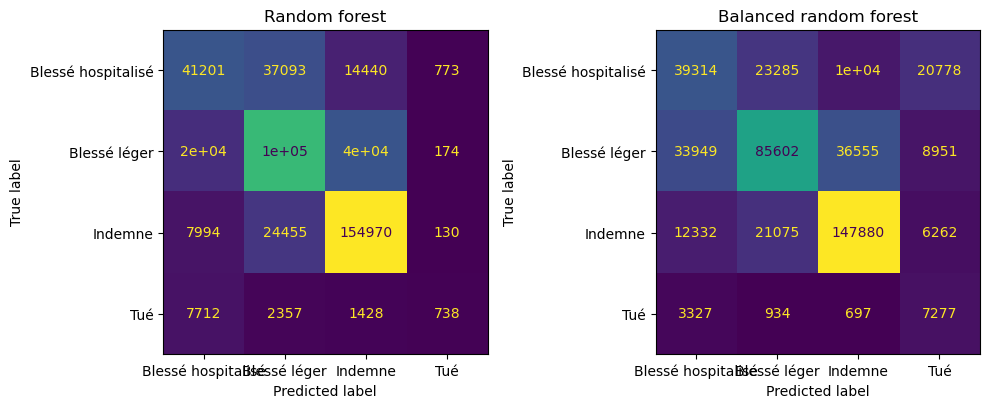

In [79]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
ConfusionMatrixDisplay.from_estimator(rf, X_test_encoded, y_test2, ax=axs[0], colorbar=False)
axs[0].set_title("Random forest")

ConfusionMatrixDisplay.from_estimator(brf, X_test_encoded, y_test2, ax=axs[1], colorbar=False)
axs[1].set_title("Balanced random forest")

fig.tight_layout()

##### Plot Precision-Recall curve for each class and iso-f1 curves

In [ ]:


# setup plot details
colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue", "teal"])

_, ax = plt.subplots(figsize=(7, 8))

f_scores = np.linspace(0.2, 0.8, num=4)
lines, labels = [], []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
    plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot(ax=ax, name="Micro-average precision-recall", color="gold")

for i, color in zip(range(n_classes), colors):
    display = PrecisionRecallDisplay(
        recall=recall[i],
        precision=precision[i],
        average_precision=average_precision[i],
    )
    display.plot(ax=ax, name=f"Precision-recall for class {i}", color=color)

# add the legend for the iso-f1 curves
handles, labels = display.ax_.get_legend_handles_labels()
handles.extend([l])
labels.extend(["iso-f1 curves"])
# set the legend and the axes
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.legend(handles=handles, labels=labels, loc="best")
ax.set_title("Extension of Precision-Recall curve to multi-class")

plt.show()

In [ ]:
scores = cross_val_score(model, X_train, y_train, cv=cross_val, scoring='roc_auc_ovo')
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

### <a id = "boosting_std">Boosting classifier</a>

In [145]:
estimator = AdaBoostClassifier(n_estimators=10)

In [146]:
eec = EasyEnsembleClassifier(n_estimators=10, estimator=estimator)

In [147]:
result_accuracy = benchmarkClassifier(eec, "Easy Ensemble Classifier", X_train_encoded, y_train2, 
                                      X_test_encoded, y_test2)

print('training_time', 'test_time', 'train_score', 'test_score', 'test_accuracy', 'balanced_accuracy', 'geometric_mean_score')
print(result_accuracy[0], result_accuracy[1], result_accuracy[2], result_accuracy[3],result_accuracy[4],
     result_accuracy[5], result_accuracy[6])
std_model_names.append("Easy Ensemble Classifier") 
std_training_times.append(result_accuracy[0]) 
std_testing_times.append(result_accuracy[1])   
std_train_scores.append(result_accuracy[2]) 
std_test_scores.append(result_accuracy[3])
std_baccuracy_score.append(result_accuracy[5])
std_geo_mean_score.append(result_accuracy[6])

Model: Easy Ensemble Classifier
---------------------------------------------------------------------------
Classification Report imbalanced :
                          pre       rec       spe        f1       geo       iba       sup

Blessé hospitalisé       0.39      0.22      0.91      0.28      0.45      0.18     93507
      Blessé léger       0.61      0.37      0.87      0.46      0.57      0.30    165057
           Indemne       0.66      0.82      0.70      0.73      0.76      0.58    187549
               Tué       0.10      0.61      0.85      0.18      0.72      0.51     12235

       avg / total       0.57      0.53      0.81      0.53      0.62      0.40    458348

---------------------------------------------------------------------------
Confusion Matrix:
[[ 20324  22412  20095  30676]
 [ 24555  60906  58989  20607]
 [  4963  15329 153728  13529]
 [  2139    981   1698   7417]]
---------------------------------------------------------------------------
Balanced accuracy: 

In [73]:


start_time = time.time()
eec.fit(X_train_encoded, y_train2)
end_time = time.time()
eec_training_time = end_time - start_time
print(eec_training_time)

507.19273710250854


In [74]:
start_time = time.time()
y_pred_eec = eec.predict(X_test_encoded)
end_time = time.time()
eec_test_time = end_time - start_time
print(eec_test_time)

49.60826897621155


Random under-sampling integrated in the learning of AdaBoost.

In [148]:
rusboost = RUSBoostClassifier(n_estimators=10, estimator=estimator)

In [149]:
result_accuracy = benchmarkClassifier(rusboost, "Random under-sampling AdaBoost Classifier", X_train_encoded, y_train2, 
                                      X_test_encoded, y_test2)

print('training_time', 'test_time', 'train_score', 'test_score', 'test_accuracy', 'balanced_accuracy', 'geometric_mean_score')
print(result_accuracy[0], result_accuracy[1], result_accuracy[2], result_accuracy[3],result_accuracy[4],
     result_accuracy[5], result_accuracy[6])
std_model_names.append("Random under-sampling AdaBoost Classifier") 
std_training_times.append(result_accuracy[0]) 
std_testing_times.append(result_accuracy[1])   
std_train_scores.append(result_accuracy[2]) 
std_test_scores.append(result_accuracy[3])
std_baccuracy_score.append(result_accuracy[5])
std_geo_mean_score.append(result_accuracy[6])

Model: Random under-sampling AdaBoost Classifier
---------------------------------------------------------------------------
Classification Report imbalanced :
                          pre       rec       spe        f1       geo       iba       sup

Blessé hospitalisé       0.41      0.26      0.90      0.32      0.49      0.22     93507
      Blessé léger       0.62      0.39      0.86      0.48      0.58      0.32    165057
           Indemne       0.67      0.81      0.72      0.73      0.76      0.59    187549
               Tué       0.11      0.60      0.87      0.18      0.72      0.50     12235

       avg / total       0.58      0.54      0.81      0.54      0.64      0.42    458348

---------------------------------------------------------------------------
Confusion Matrix:
[[ 24658  23521  16819  28509]
 [ 25778  64463  56978  17838]
 [  6552  15670 151484  13843]
 [  2566   1061   1290   7318]]
---------------------------------------------------------------------------
Ba

In [75]:


start_time = time.time()
rusboost.fit(X_train_encoded, y_train2)
end_time = time.time()
rusboost_training_time = end_time - start_time
print(rusboost_training_time)

start_time = time.time()
y_pred_rusboost = rusboost.predict(X_test_encoded)
end_time = time.time()
rusboost_test_time = end_time - start_time
print(rusboost_test_time)

392.8191637992859
42.198992013931274


In [78]:
print("Easy ensemble classifier performance:")
print(
    f"Balanced accuracy: {balanced_accuracy_score(y_test2, y_pred_eec):.2f} - "
    f"Geometric mean {geometric_mean_score(y_test2, y_pred_eec):.2f}"
)
print("RUSBoost classifier performance:")
print(
    f"Balanced accuracy: {balanced_accuracy_score(y_test2, y_pred_rusboost):.2f} - "
    f"Geometric mean {geometric_mean_score(y_test2, y_pred_rusboost):.2f}"
)

Easy ensemble classifier performance:
Balanced accuracy: 0.50 - Geometric mean 0.45
RUSBoost classifier performance:
Balanced accuracy: 0.52 - Geometric mean 0.47


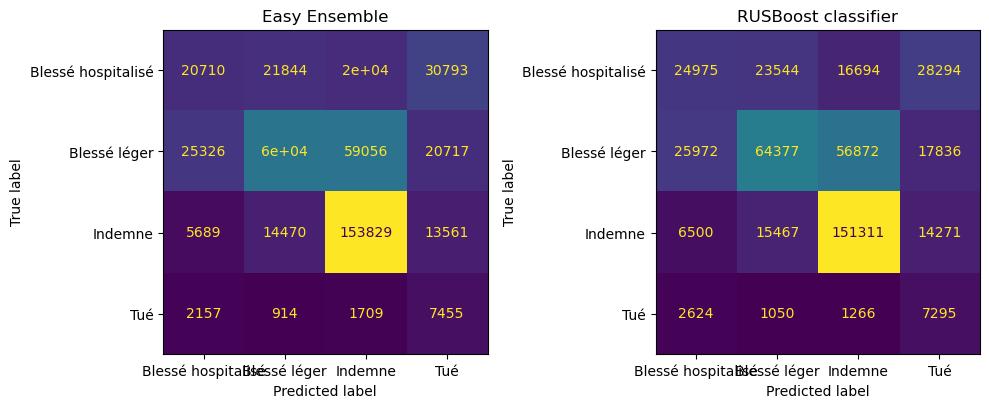

In [79]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

ConfusionMatrixDisplay.from_estimator(eec, X_test_encoded, y_test2, ax=axs[0], colorbar=False)
axs[0].set_title("Easy Ensemble")
ConfusionMatrixDisplay.from_estimator(
    rusboost, X_test_encoded, y_test2, ax=axs[1], colorbar=False
)
axs[1].set_title("RUSBoost classifier")

fig.tight_layout()
plt.show()

In [80]:
#Score du modèle eec 
eec.score(X_test_encoded, y_test2)

0.5278783806190929

In [81]:
#Score du modèle rusboost 
rusboost.score(X_test_encoded, y_test2)

0.5409819613045109

### <a id = "tb_std">Tablau comparatif</a>

In [154]:
# Calling DataFrame constructor after zipping
# both lists, with columns specified
Standardised_results = pd.DataFrame(list(zip(std_model_names, std_training_times, std_testing_times, std_train_scores, std_test_scores, std_baccuracy_score, std_geo_mean_score)),
                  columns =['Model Name', 'Train time', 'Test time', 'Train score', 'Test score', 'balanced_accuracy', 'geometric_mean_score']
                 )
# Exporting the RESULT DataFrame into a CSV file
Standardised_results.to_csv('Acc_Results_Standardised.csv')
Standardised_results

,Model Name,Train time,Test time,Train score,Test score,balanced_accuracy,geometric_mean_score
0,Stochastic_Gradient-Descent,38.634431,0.723625,63.210,62.546,0.460,0.085
1,Stochastic_Gradient_Descent1500,119.896145,1.126454,64.358,61.128,0.407,0.084
2,Logistic_Regression,2645.558733,1.735986,62.559,64.350,0.471,0.306
3,Ridge Classifier,46.943504,1.313771,61.165,63.227,0.441,0.097
4,Random_Forest_Classifier,966.679905,43.129599,64.358,65.728,0.490,0.343
5,Balanced_Random_Forest_Classifier,345.425589,25.440797,63.210,61.105,0.581,0.565
6,Easy Ensemble Classifier,366.967961,56.381592,99.939,52.880,0.503,0.447
7,Random under-sampling AdaBoost Classifier,448.895083,49.028802,68.460,54.091,0.515,0.472
8,Bagging Classifier,23633.038328,151.925985,52.875,64.946,0.494,0.381
9,Balanced Bagging Classifier,2824.089626,67.828174,54.049,60.629,0.570,0.559


<div class="alert alert-block alert-info">
<h2><a id = "data_desequilibre">Jeux de données déséquilibrés</a></h2>
</div>


#####  Sur-échantillonnage (Oversampling) 

In [92]:
# (a) A partir de X_train et y_train, création de deux nouveaux ensembles de données : 
# (X_ro, y_ro) obtenus par Oversampling aléatoire (RandomOverSampler) 
randomOs = RandomOverSampler()
start_time = time.time()
X_ro, y_ro = randomOs.fit_resample(X_train_encoded, y_train2)
end_time = time.time()
execution_time = end_time - start_time
print(execution_time)
print('RandomOverSampler resampled dataset shape %s' % Counter(y_ro))


41.59516382217407
RandomOverSampler resampled dataset shape Counter({'Blessé hospitalisé': 750194, 'Blessé léger': 750194, 'Tué': 750194, 'Indemne': 750194})


In [78]:
# Creating Dataframe
df_randomOS = pd.concat([X_ro, X_test_encoded, y_ro, y_test2])
# Exporting the DataFrame into a CSV file
df_randomOS.to_csv('Acc_Results_data_randomOS.csv')
df_randomOS.head()

,jour_de_la_semaine,heure,place_0.0,place_1.0,place_10.0,place_2.0,place_3.0,place_4.0,place_5.0,place_6.0,...,col_Deux véhicules – par le coté,col_Deux véhicules – par l’arrière,col_Non renseigné,col_Sans collision,col_Trois véhicules et plus - collisions multiples,col_Trois véhicules et plus – en chaîne,age_acc_an,nbv,occutc,0
0,3.0,8.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.290336,-0.742861,-0.046606,NaN
1,6.0,8.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,-0.249871,-0.087437,-0.046606,NaN
2,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.746996,-0.087437,-0.046606,NaN
3,0.0,15.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,-0.305208,1.223410,-0.046606,NaN
4,2.0,23.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,2.069290,-0.087437,-0.046606,NaN


In [93]:
# et (X_sm, y_sm) obtenus par SMOTE (SMOTE).
smote = SMOTE()
start_time = time.time()
X_sm, y_sm = smote.fit_resample(X_train_encoded, y_train2)
end_time = time.time()
execution_time = end_time - start_time
print(execution_time)
print('SMOTE resampled dataset shape %s' % Counter(y_sm))

17393.02422809601
SMOTE resampled dataset shape Counter({'Blessé hospitalisé': 750194, 'Blessé léger': 750194, 'Tué': 750194, 'Indemne': 750194})


In [ ]:
# Creating Dataframe
df_smote = pd.concat([X_ro, X_test_encoded, y_ro, y_test2])
# Exporting the DataFrame into a CSV file
df_smote.to_csv('Acc_Results_data_smoteOS.csv')
df_smote.head()

In [140]:
type(X_ro)

pandas.core.frame.DataFrame

In [141]:
X_ro.columns

Index(['jour_de_la_semaine', 'place_0.0', 'place_1.0', 'place_10.0',
       'place_2.0', 'place_3.0', 'place_4.0', 'place_5.0', 'place_6.0',
       'place_7.0',
       ...
       'col_Deux véhicules – par le coté',
       'col_Deux véhicules – par l’arrière', 'col_Non renseigné',
       'col_Sans collision',
       'col_Trois véhicules et plus - collisions multiples',
       'col_Trois véhicules et plus – en chaîne', 'age_acc_an', 'nbv',
       'occutc', 'heure'],
      dtype='object', length=266)

In [79]:
os_model_names=[]
os_training_times=[]
os_testing_times=[]
os_test_scores=[]

In [146]:
# Création et entrainement modèles
# Classifier using Logistic Regression
training_time, test_time, test_score, logreg_accuracy_ro = benchmarkClassifier(hist_gradient_boosting, 
                                            "hist_gradient_boosting", X_ro, y_ro, X_test_encoded, y_test2)
os_model_names.append("RandOS_hist_gradient_boosting") 
os_training_times.append(training_time) 
os_testing_times.append(test_time) 
os_test_scores.append(test_score)
# X_train_encoded, X_test_encoded, y_train2, y_test2

col_0               Blessé hospitalisé  Blessé léger  Indemne    Tué
grav                                                                
Indemne                          10827         22314   145341   9067
Blessé léger                     30984         86842    33688  13543
Blessé hospitalisé               34161         22684     9301  27361
Tué                               2386           824      601   8424
Classification Report imbalanced :
                          pre       rec       spe        f1       geo       iba       sup

Blessé hospitalisé       0.44      0.37      0.88      0.40      0.57      0.30     93507
      Blessé léger       0.65      0.53      0.84      0.58      0.67      0.43    165057
           Indemne       0.77      0.77      0.84      0.77      0.81      0.65    187549
               Tué       0.14      0.69      0.89      0.24      0.78      0.60     12235

       avg / total       0.64      0.60      0.85      0.61      0.71      0.50    458348



In [103]:
result_accuracy = benchmarkClassifier(hist_gradient_boosting, "hist_gradient_boosting",  X_ro, y_ro, 
                                      X_test_encoded, y_test2)

print('training_time', 'test_time', 'train_score', 'test_score', 'hgbc_accuracy', 'balanced_accuracy', 'geometric_mean_score')
print(result_accuracy[0], result_accuracy[1], result_accuracy[2], result_accuracy[3],result_accuracy[4],
     result_accuracy[5], result_accuracy[6])

Model: hist_gradient_boosting
---------------------------------------------------------------------------
Classification Report imbalanced :
                          pre       rec       spe        f1       geo       iba       sup

Blessé hospitalisé       0.44      0.37      0.88      0.40      0.57      0.31     93507
      Blessé léger       0.66      0.52      0.85      0.58      0.67      0.43    165057
           Indemne       0.77      0.78      0.84      0.77      0.81      0.65    187549
               Tué       0.14      0.69      0.89      0.24      0.78      0.60     12235

       avg / total       0.64      0.60      0.85      0.61      0.71      0.50    458348

---------------------------------------------------------------------------
Confusion Matrix:
[[ 34302  22502   9410  27293]
 [ 31010  86429  34091  13527]
 [ 10898  21885 145744   9022]
 [  2370    838    606   8421]]
---------------------------------------------------------------------------
Balanced accuracy: 0.

In [147]:
# Création et entrainement modèles après SMOTE
training_time, test_time, test_score, ridge_accuracy_sm = benchmarkClassifier(HistGradientBoostingClassifier, 
                                            "hist_gradient_boosting", X_sm, y_sm, X_test_encoded, y_test2)
print(training_time, test_time, test_score, ridge_accuracy_sm)
os_model_names.append("Smote_hist_gradient_boosting") 
os_training_times.append(training_time) 
os_testing_times.append(test_time) 
os_test_scores.append(test_score)

col_0               Blessé hospitalisé  Blessé léger  Indemne   Tué
grav                                                               
Indemne                           9584         22882   154517   566
Blessé léger                     23022        100730    40567   738
Blessé hospitalisé               42311         34034    14116  3046
Tué                               6769          1915     1403  2148
Classification Report imbalanced :
                          pre       rec       spe        f1       geo       iba       sup

Blessé hospitalisé       0.52      0.45      0.89      0.48      0.64      0.39     93507
      Blessé léger       0.63      0.61      0.80      0.62      0.70      0.48    165057
           Indemne       0.73      0.82      0.79      0.78      0.81      0.66    187549
               Tué       0.33      0.18      0.99      0.23      0.42      0.16     12235

       avg / total       0.64      0.65      0.82      0.65      0.72      0.52    458348



In [104]:
result_accuracy = benchmarkClassifier(hist_gradient_boosting, "hist_gradient_boosting", X_sm, y_sm, 
                                      X_test_encoded, y_test2)

print('training_time', 'test_time', 'train_score', 'test_score', 'hgbc_accuracy_sm', 'balanced_accuracy', 'geometric_mean_score')
print(result_accuracy[0], result_accuracy[1], result_accuracy[2], result_accuracy[3],result_accuracy[4],
     result_accuracy[5], result_accuracy[6])

Model: hist_gradient_boosting
---------------------------------------------------------------------------
Classification Report imbalanced :
                          pre       rec       spe        f1       geo       iba       sup

Blessé hospitalisé       0.52      0.45      0.89      0.48      0.63      0.38     93507
      Blessé léger       0.63      0.61      0.80      0.62      0.70      0.48    165057
           Indemne       0.73      0.82      0.79      0.78      0.81      0.66    187549
               Tué       0.35      0.16      0.99      0.22      0.40      0.15     12235

       avg / total       0.64      0.65      0.82      0.65      0.72      0.52    458348

---------------------------------------------------------------------------
Confusion Matrix:
[[ 42137  34427  14290   2653]
 [ 22553 101312  40576    616]
 [  9341  23023 154705    480]
 [  6894   1908   1448   1985]]
---------------------------------------------------------------------------
Balanced accuracy: 0.

In [156]:
# Classifier using Ridge regression
training_time, test_time, test_score, ridge_accuracy_ro = benchmarkClassifier(ridge_clf, 
                                            "Ridge Classifier", X_ro, y_ro, X_test_encoded, y_test2)
#print(training_time, test_time, test_scores, ridge_accuracy_ro)
os_model_names.append("RandOS_Ridge_Classifier") 
os_training_times.append(training_time) 
os_testing_times.append(test_time) 
os_test_scores.append(test_score)

Model: Ridge Classifier
---------------------------------------------------------------------------
Classification Report :
                    precision    recall  f1-score   support

Blessé hospitalisé       0.45      0.25      0.32     93507
      Blessé léger       0.65      0.47      0.55    165057
           Indemne       0.72      0.81      0.76    187549
               Tué       0.11      0.70      0.20     12235

          accuracy                           0.57    458348
         macro avg       0.48      0.56      0.46    458348
      weighted avg       0.62      0.57      0.58    458348

Confusion Matrix:
[[ 23144  23407  13661  33295]
 [ 20971  78272  45297  20517]
 [  5527  17392 151669  12961]
 [  1667   1009    963   8596]]


In [158]:
# Classifier using Ridge regression
training_time, test_time, test_score, ridge_accuracy_sm = benchmarkClassifier(ridge_clf, 
                                            "Ridge Classifier", X_sm, y_sm, X_test_encoded, y_test2)
print(training_time, test_time, test_score, ridge_accuracy_sm)
os_model_names.append("Smote_Ridge_Classifier") 
os_training_times.append(training_time) 
os_testing_times.append(test_time) 
os_test_scores.append(test_score)

Model: Ridge Classifier
---------------------------------------------------------------------------
Classification Report :
                    precision    recall  f1-score   support

Blessé hospitalisé       0.44      0.25      0.32     93507
      Blessé léger       0.65      0.48      0.55    165057
           Indemne       0.72      0.80      0.76    187549
               Tué       0.11      0.69      0.20     12235

          accuracy                           0.57    458348
         macro avg       0.48      0.56      0.46    458348
      weighted avg       0.62      0.57      0.58    458348

Confusion Matrix:
[[ 23455  23645  13597  32810]
 [ 21702  78926  44433  19996]
 [  5884  18633 150630  12402]
 [  1725   1083    990   8437]]
188.36788606643677 1.0930750370025635 0.6325783029488511 0.5704137467601037


In [108]:
result_accuracy = benchmarkClassifier(ridge_clf, "Ridge Classifier", X_sm, y_sm, 
                                      X_test_encoded, y_test2)

print('training_time', 'test_time', 'train_score', 'test_score', 'ridge_accuracy_sm', 'balanced_accuracy', 'geometric_mean_score')
print(result_accuracy[0], result_accuracy[1], result_accuracy[2], result_accuracy[3],result_accuracy[4],
     result_accuracy[5], result_accuracy[6])

Model: Ridge Classifier
---------------------------------------------------------------------------
Classification Report imbalanced :
                          pre       rec       spe        f1       geo       iba       sup

Blessé hospitalisé       0.44      0.25      0.92      0.32      0.48      0.22     93507
      Blessé léger       0.64      0.48      0.85      0.55      0.64      0.39    165057
           Indemne       0.72      0.80      0.78      0.76      0.79      0.63    187549
               Tué       0.12      0.69      0.85      0.20      0.77      0.58     12235

       avg / total       0.62      0.57      0.84      0.58      0.67      0.46    458348

---------------------------------------------------------------------------
Confusion Matrix:
[[ 23619  23712  13570  32606]
 [ 22009  79029  44358  19661]
 [  5927  18721 150428  12473]
 [  1720   1100    995   8420]]
---------------------------------------------------------------------------
Balanced accuracy: 0.555 - 

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 298, in _score
    y_pred = method_caller(clf, "predict_proba", X)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'RidgeClassifier' object has no attribute 'predict_proba'

  warnings.warn(
/opt/anaconda3/lib/python3.

Mean AUC Score: nan  temps execution en secondes :  140.57352232933044
training_time test_time train_score test_score ridge_accuracy_sm balanced_accuracy geometric_mean_score
112.13066291809082 0.9237959384918213 57.395 57.052 57.052 0.555 0.508


/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 298, in _score
    y_pred = method_caller(clf, "predict_proba", X)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'RidgeClassifier' object has no attribute 'predict_proba'

  warnings.warn(


In [109]:
# Classifier using Logistic Regression
result_accuracy = benchmarkClassifier(logreg, "RandOS_Logistic_Regression", X_ro, y_ro, 
                                      X_test_encoded, y_test2)

print('training_time', 'test_time', 'train_score', 'test_score', 'RandOS_Logistic_Regression', 'balanced_accuracy', 'geometric_mean_score')
print(result_accuracy[0], result_accuracy[1], result_accuracy[2], result_accuracy[3],result_accuracy[4],
     result_accuracy[5], result_accuracy[6])


#os_model_names.append("RandOS_Logistic_Regression") 
#os_training_times.append(training_time) 
#os_testing_times.append(test_time) 
#os_test_scores.append(test_score)

Model: RandOS_Logistic_Regression
---------------------------------------------------------------------------
Classification Report imbalanced :
                          pre       rec       spe        f1       geo       iba       sup

Blessé hospitalisé       0.43      0.34      0.88      0.38      0.54      0.28     93507
      Blessé léger       0.65      0.49      0.85      0.56      0.64      0.40    165057
           Indemne       0.74      0.78      0.81      0.76      0.80      0.64    187549
               Tué       0.13      0.66      0.88      0.22      0.76      0.57     12235

       avg / total       0.63      0.58      0.84      0.60      0.69      0.48    458348

---------------------------------------------------------------------------
Confusion Matrix:
[[ 31353  22942  10950  28262]
 [ 29980  80608  39040  15429]
 [  9657  20162 147162  10568]
 [  2483    942    730   8080]]
---------------------------------------------------------------------------
Balanced accuracy

In [112]:
result_accuracy = benchmarkClassifier(logreg, "Smote_Logistic_Regression", X_sm, y_sm, 
                                      X_test_encoded, y_test2)

print('training_time', 'test_time', 'train_score', 'test_score', 'logreg_accuracy_sm', 'balanced_accuracy', 'geometric_mean_score')
print(result_accuracy[0], result_accuracy[1], result_accuracy[2], result_accuracy[3],result_accuracy[4],
     result_accuracy[5], result_accuracy[6])

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model: Smote_Logistic_Regression
---------------------------------------------------------------------------
Classification Report imbalanced :
                          pre       rec       spe        f1       geo       iba       sup

Blessé hospitalisé       0.42      0.34      0.88      0.38      0.55      0.29     93507
      Blessé léger       0.64      0.49      0.85      0.55      0.64      0.40    165057
           Indemne       0.74      0.78      0.81      0.76      0.80      0.64    187549
               Tué       0.13      0.64      0.88      0.22      0.75      0.56     12235

       avg / total       0.63      0.58      0.84      0.60      0.69      0.48    458348

---------------------------------------------------------------------------
Confusion Matrix:
[[ 32150  23200  10967  27190]
 [ 31190  80667  38733  14467]
 [ 10125  20885 146871   9668]
 [  2537   1056    777   7865]]
---------------------------------------------------------------------------
Balanced accuracy:

In [159]:
# Calling DataFrame constructor after zipping
# both lists, with columns specified
overSampling_df_results = pd.DataFrame(list(zip(os_model_names, os_training_times, os_testing_times, os_test_scores)),
                  columns =['Model Name', 'Execution time', 'Test time', 'Test score']
                 )
# Exporting the RESULT DataFrame into a CSV file
overSampling_df_results.to_csv('Acc_Results_overSampling.csv')
overSampling_df_results

,Model Name,Execution time,Test time,Test score
0,RandOS_hist_gradient_boosting,654.468295,5.616827,0.599475
1,Smote_hist_gradient_boosting,742.777473,6.175871,0.653883
2,RandOS_Ridge_Classifier,372.139751,1.334252,0.570922
3,Smote_Ridge_Classifier,188.367886,1.093075,0.570414


##### Sous-échantillonnage (Undersampling)

In [113]:
# A partir de X_train et y_train, créer deux nouveaux ensembles de données 
# (X_ru, y_ru) obtenus par Undersampling aléatoire (RandomUnderSampler)
rUs = RandomUnderSampler()
start_time = time.time()
X_ru, y_ru = rUs.fit_resample(X_train_encoded, y_train2)
end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

# Affichage du nombre d'éléments de chaque classe du nouvel ensemble obtenu.
print('RandomUnderSampler resampled dataset shape %s' % Counter(y_ru))

17.988421201705933
RandomUnderSampler resampled dataset shape Counter({'Blessé hospitalisé': 48942, 'Blessé léger': 48942, 'Indemne': 48942, 'Tué': 48942})


In [114]:
result_accuracy = benchmarkClassifier(logreg, "RandUnderS_Logistic_Regression", X_ru, y_ru, 
                                      X_test_encoded, y_test2)

print('training_time', 'test_time', 'train_score', 'test_score', 'logreg_accuracy_RandUnderS', 'balanced_accuracy', 'geometric_mean_score')
print(result_accuracy[0], result_accuracy[1], result_accuracy[2], result_accuracy[3],result_accuracy[4],
     result_accuracy[5], result_accuracy[6])

Model: RandUnderS_Logistic_Regression
---------------------------------------------------------------------------
Classification Report imbalanced :
                          pre       rec       spe        f1       geo       iba       sup

Blessé hospitalisé       0.43      0.34      0.88      0.38      0.55      0.28     93507
      Blessé léger       0.64      0.49      0.85      0.56      0.64      0.40    165057
           Indemne       0.74      0.78      0.81      0.76      0.80      0.63    187549
               Tué       0.13      0.66      0.88      0.22      0.76      0.57     12235

       avg / total       0.63      0.58      0.84      0.59      0.69      0.48    458348

---------------------------------------------------------------------------
Confusion Matrix:
[[ 31527  22896  10836  28248]
 [ 30394  80615  38578  15470]
 [  9681  20814 146442  10612]
 [  2444    977    723   8091]]
---------------------------------------------------------------------------
Balanced accu

In [115]:
result_accuracy = benchmarkClassifier(ridge_clf, "Ridge Classifier", X_ru, y_ru, 
                                      X_test_encoded, y_test2)

print('training_time', 'test_time', 'train_score', 'test_score', 'ridge_accuracy_RandUnderS', 'balanced_accuracy', 'geometric_mean_score')
print(result_accuracy[0], result_accuracy[1], result_accuracy[2], result_accuracy[3],result_accuracy[4],
     result_accuracy[5], result_accuracy[6])

Model: Ridge Classifier
---------------------------------------------------------------------------
Classification Report imbalanced :
                          pre       rec       spe        f1       geo       iba       sup

Blessé hospitalisé       0.45      0.25      0.92      0.32      0.48      0.22     93507
      Blessé léger       0.65      0.47      0.86      0.55      0.64      0.39    165057
           Indemne       0.72      0.80      0.78      0.76      0.79      0.63    187549
               Tué       0.11      0.70      0.85      0.20      0.77      0.59     12235

       avg / total       0.62      0.57      0.84      0.58      0.67      0.46    458348

---------------------------------------------------------------------------
Confusion Matrix:
[[ 23417  23319  13559  33212]
 [ 21674  78305  44714  20364]
 [  5562  18081 150886  13020]
 [  1664   1024    934   8613]]
---------------------------------------------------------------------------
Balanced accuracy: 0.558 - 

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 298, in _score
    y_pred = method_caller(clf, "predict_proba", X)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'RidgeClassifier' object has no attribute 'predict_proba'

  warnings.warn(
/opt/anaconda3/lib/python3.

Mean AUC Score: nan  temps execution en secondes :  203.88849997520447
training_time test_time train_score test_score ridge_accuracy_RandUnderS balanced_accuracy geometric_mean_score
2.6470839977264404 2.703217029571533 56.178 56.992 56.992 0.558 0.509


/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 298, in _score
    y_pred = method_caller(clf, "predict_proba", X)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'RidgeClassifier' object has no attribute 'predict_proba'

  warnings.warn(


In [116]:
result_accuracy = benchmarkClassifier(hist_gradient_boosting, "hist_gradient_boosting", X_ru, y_ru, 
                                      X_test_encoded, y_test2)

print('training_time', 'test_time', 'train_score', 'test_score', 'hgbc_accuracy_RandUnderS', 'balanced_accuracy', 'geometric_mean_score')
print(result_accuracy[0], result_accuracy[1], result_accuracy[2], result_accuracy[3],result_accuracy[4],
     result_accuracy[5], result_accuracy[6])

Model: hist_gradient_boosting
---------------------------------------------------------------------------
Classification Report imbalanced :
                          pre       rec       spe        f1       geo       iba       sup

Blessé hospitalisé       0.43      0.36      0.88      0.39      0.56      0.30     93507
      Blessé léger       0.65      0.51      0.85      0.57      0.66      0.42    165057
           Indemne       0.77      0.77      0.84      0.77      0.80      0.64    187549
               Tué       0.14      0.70      0.88      0.23      0.78      0.60     12235

       avg / total       0.64      0.59      0.85      0.61      0.70      0.49    458348

---------------------------------------------------------------------------
Confusion Matrix:
[[ 33620  22362   9451  28074]
 [ 31976  84782  34120  14179]
 [ 10960  22173 144956   9460]
 [  2272    854    596   8513]]
---------------------------------------------------------------------------
Balanced accuracy: 0.

In [1]:
us_model_names=[]
us_training_times=[]
us_testing_times=[]
us_test_scores=[]

In [ ]:
# Classifier using Ridge regression before RandomUnderSimpler
training_time, test_time, test_score, ridge_accuracy_ru = benchmarkClassifier(ridge_clf, 
                                            "Ridge Classifier", X_ru, y_ru, X_test_encoded, y_test2)
print(training_time, test_time, test_scores, ridge_accuracy_ru)
us_model_names.append("RandUnderS_Ridge_Classifier") 
us_training_times.append(training_time) 
us_testing_times.append(test_time) 
us_test_scores.append(test_score)

In [ ]:
# Classifier using Logistic Regression
training_time, test_time, test_score, logreg_accuracy_ru = benchmarkClassifier(logreg, 
                                            "Logistic Regression", X_ru, y_ru, X_test_encoded, y_test2)
us_model_names.append("RandUnderS_Logistic_Regression") 
us_training_times.append(training_time) 
us_testing_times.append(test_time) 
us_test_scores.append(test_score)

In [172]:
# Entraînement du modèle sur l'ensemble issu du RandomUnderSampler, 
training_time, test_time, test_score, histGB_accuracy_ru = benchmarkClassifier(hist_gradient_boosting, 
                                            "hist_gradient_boosting", X_ru, y_ru, X_test_encoded, y_test2)
us_model_names.append("RandUnderS_hist_gradient_boosting") 
us_training_times.append(training_time) 
us_testing_times.append(test_time) 
us_test_scores.append(test_score)

col_0               Blessé hospitalisé  Blessé léger  Indemne    Tué
grav                                                                
Indemne                          10947         21773   145267   9567
Blessé léger                     31650         84734    34398  14280
Blessé hospitalisé               33238         22611     9514  28145
Tué                               2158           842      583   8653
Classification Report imbalanced :
                          pre       rec       spe        f1       geo       iba       sup

Blessé hospitalisé       0.43      0.36      0.88      0.39      0.56      0.30     93508
      Blessé léger       0.65      0.51      0.85      0.57      0.66      0.42    165062
           Indemne       0.77      0.77      0.84      0.77      0.80      0.64    187554
               Tué       0.14      0.71      0.88      0.24      0.79      0.61     12236

       avg / total       0.64      0.59      0.85      0.61      0.70      0.49    458360



In [173]:
print("Accuracy:", accuracy_score(y_test, y_pred_ru))

Accuracy: 0.5931843965442011


##### Logistic Regression

In [ ]:
# logreg = LogisticRegression(max_iter=500)

In [80]:
# Modification du constructeur du modèle
logreg = LogisticRegression(random_state=0, max_iter=2500)

###### Logistic Regression estimator with dropped categorical features

In [96]:
# create an estimator where the categorical features are dropped
dropper_categorical_preprocessor = make_column_transformer(
    ("drop", make_column_selector(dtype_include="category")), remainder="passthrough"
)

dropper_preprocessor = ColumnTransformer([
    ('dropper', dropper_categorical_preprocessor, categorical_columns),
    ('standard_scaler', numerical_preprocessor, numerical_columns)])

#  create our dropped model
#hist_dropped = make_pipeline(
#    dropper_preprocessor, HistGradientBoostingClassifier() #random_state=42)
#)
logreg_dropped = Pipeline(steps=[
    ('scaler', dropper_preprocessor), 
    ('Logistic_Regressiont_dropped', logreg) 
])

###### Logistic Regression estimator with one-hot encoding

In [97]:
one_hot_categorical_preprocessor = OneHotEncoder(sparse=False, 
                                                 handle_unknown="ignore")# to solve the potential issues due to rare categories

one_hot_preprocessor = ColumnTransformer([
    ('one_hot_encoder', one_hot_categorical_preprocessor, categorical_columns),
    ('standard_scaler', numerical_preprocessor, numerical_columns)])

#  create our model
logreg_one_hot = Pipeline(steps=[
    ('one_hot_preprocessor', one_hot_preprocessor), 
    ('Logistic_Regressiont_one_hot', logreg)
])

###### Logistic Regression estimator with ordinal encoding

In [98]:
ordinal_preprocessor = ColumnTransformer([
    ('ordinal_encoder', categorical_preprocessor, categorical_columns),
    ('standard_scaler', numerical_preprocessor, numerical_columns)])

#  create our model
logreg_ordinal = Pipeline(steps=[
    ('ordinal_preprocessor', ordinal_preprocessor), 
    ('Logistic_Regressiont_ordinal', logreg)
])

###### Logistic Regression estimator with ordinal encoding and one-hot encoding


In [99]:
categorical_columns.remove("jour_de_la_semaine")
categorical_preprocessor = OrdinalEncoder(handle_unknown="use_encoded_value",
                                          unknown_value=-1)

preprocessor = ColumnTransformer([
    ('ordinal_encoder', categorical_preprocessor, ['jour_de_la_semaine']),
    ('one_hot_encoder', one_hot_categorical_preprocessor, categorical_columns),
    ('standard_scaler', MinMaxScaler(), numerical_columns)])
#  create our model
logreg_one_hot_ordinal = Pipeline(steps=[
    ('standard_scaler_preprocessor', preprocessor), 
    ('Logistic_Regressiont_one_hot_ordinal', logreg)
])

In [100]:
categorical_columns_selector = selector(dtype_include="category")
categorical_columns = categorical_columns_selector(accRoutierFr.drop(["grav"], axis=1))

In [129]:
# check its generalization performance.

start_time = time.time()

# Train the classifier
logreg_one_hot_ordinal.fit(X_train, y_train)

end_time = time.time()
execution_time = end_time - start_time

print(f"Execution time: {execution_time:.4f} seconds")

Execution time: 2308.3794 seconds


In [130]:
# Make predictions on the testing data
y_pred_logreg = logreg_one_hot_ordinal.predict(X_test)

In [131]:
print("Accuracy:", accuracy_score(y_test, y_pred_logreg))

Accuracy: 0.643701457369753


In [133]:
# check its generalization performance.

start_time = time.time()

# Train the classifier
logreg_one_hot_ordinal.fit(X_ru, y_ru)

end_time = time.time()
execution_time = end_time - start_time

print(f"Execution time: {execution_time:.4f} seconds")

Execution time: 170.5252 seconds


In [134]:
# Make predictions on the testing data
y_pred_logreg_ru = logreg_one_hot_ordinal.predict(X_test)

In [135]:
print("Accuracy:", accuracy_score(y_test, y_pred_logreg_ru))

Accuracy: 0.5806745789335893


In [101]:
compare_classifiers_models([logreg_dropped, logreg_one_hot, logreg_ordinal, logreg_one_hot_ordinal])

Model: Logistic_Regressiont_dropped
Classification Report :


/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                    precision    recall  f1-score   support

Blessé hospitalisé       0.25      0.00      0.00     93508
      Blessé léger       0.42      0.43      0.43    165062
           Indemne       0.45      0.71      0.55    187554
               Tué       0.00      0.00      0.00     12236

          accuracy                           0.44    458360
         macro avg       0.28      0.28      0.24    458360
      weighted avg       0.39      0.44      0.38    458360

Confusion Matrix:
[[     1  37391  56116      0]
 [     2  70607  94453      0]
 [     1  55232 132321      0]
 [     0   3964   8272      0]]
Model: Logistic_Regressiont_one_hot
Classification Report :
                    precision    recall  f1-score   support

Blessé hospitalisé       0.53      0.39      0.45     93508
      Blessé léger       0.61      0.60      0.61    165062
           Indemne       0.70      0.84      0.77    187554
               Tué       0.50      0.05      0.08     12236

          ac

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [116]:
categorical_columns_selector = selector(dtype_include="category")
categorical_columns = categorical_columns_selector(accRoutierFr.drop(["grav"], axis=1))

In [ ]:
# Define a list of classifier models result
results = [
    dropped_result,
    one_hot_result,
    ordinal_result,
    native_result
]

# Iterate through the results and evaluate each
for scores in results:
    # Print the cross-validation scores
    print("Cross-validation scores:", scores)
    print("Mean accuracy:", scores.mean())
    print("Standard deviation:", scores.std())

<div class="alert alert-block alert-info">
<h2><a id = "tuning_gridsearch">Hyperparameter tuning by grid-search</a></h2>
</div>

In [94]:
# Without hyperparameter tuning
cv_results = cross_validate(hist_ordinal, X, y, cv=5)
cv_results = pd.DataFrame(cv_results)
cv_results

,fit_time,score_time,test_score
0,122.042535,7.362739,0.646622
1,117.618042,6.381552,0.659412
2,119.184629,7.044930,0.666919
3,123.935749,6.133913,0.664940
4,117.067318,7.337887,0.626743


In [95]:
#23:35 le 10-09-2023
print(
    "Generalization score without hyperparameters tuning:\n"
    f"{cv_results['test_score'].mean():.3f} ± {cv_results['test_score'].std():.3f}"
)

Generalization score without hyperparameters tuning:
0.653 ± 0.017


In [96]:
# With hyperparameter tuning : use of a grid-search strategy
#00:02 le 11-09-2023
param_grid = {
    'model_hist_ordinal__learning_rate': (0.01, 0.1, 1, 10),
    'model_hist_ordinal__max_leaf_nodes': (3, 10, 30)}
model_grid_search = GridSearchCV(hist_ordinal, param_grid=param_grid,
                                 n_jobs=2, cv=2)
model_grid_search.fit(X, y)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('ordinal_preprocessor',
                                        ColumnTransformer(transformers=[('ordinal_encoder',
                                                                         ColumnTransformer(remainder='passthrough',
                                                                                           transformers=[('ordinalencoder',
                                                                                                          OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                                         unknown_value=nan),
                                                                                                          <sklearn.compose._column_transformer.make_column_selector object at 0x7fadadd9f9d0>)],
                                                                                           verbo...
                                                                          'obsm',
                                                                          'choc',
                                                                          'manv',
                                                                          'catv_Label',
                                                                          'lum',
                                                                          'agg',
                                                                          'int',
                                                                          'atm',
                                                                          'col',
                                                                          'jour_de_la_semaine', ...]),
                                                                        ('standard_scaler',
                                                                         StandardScaler(),
                                                                         ['age_acc_an',
                                                                          'nbv',
                                                                          'occutc'])])),
                                       ('model_hist_ordinal',
                                        HistGradientBoostingClassifier(random_state=52))]),
             n_jobs=2,
             param_grid={'model_hist_ordinal__learning_rate': (0.01, 0.1, 1,
                                                               10),
                         'model_hist_ordinal__max_leaf_nodes': (3, 10, 30)})

In [97]:
time.time() # 17min

1694384319.553673

In [98]:
# The best combination is selected by keeping the combination leading to the best mean cross-validated score.
cv_results_grid = pd.DataFrame(model_grid_search.cv_results_)
cv_results_grid[[
    "param_model_hist_ordinal__learning_rate",
    "param_model_hist_ordinal__max_leaf_nodes",
    "mean_test_score",
    "std_test_score",
    "rank_test_score"
]]

,param_model_hist_ordinal__learning_rate,param_model_hist_ordinal__max_leaf_nodes,mean_test_score,std_test_score,rank_test_score
0,0.01,3,0.551962,0.013395,9
1,0.01,10,0.608043,0.001690,7
2,0.01,30,0.628779,0.005061,3
3,0.1,3,0.621638,0.003060,4
4,0.1,10,0.645295,0.005221,2
5,0.1,30,0.648576,0.006498,1
6,1,3,0.557389,0.002679,8
7,1,10,0.611350,0.011249,6
8,1,30,0.617513,0.011942,5
9,10,3,0.392159,0.120301,11


In [99]:
model_grid_search.best_params_

{'model_hist_ordinal__learning_rate': 0.1,
 'model_hist_ordinal__max_leaf_nodes': 30}

In [100]:
# using knowledge from the full dataset to both decide our model’s hyper-parameters and to train the refitted model

start_time = time.time()

model_grid_search.fit(X_train, y_train)
accuracy = model_grid_search.score(X_test, y_test)
print(f"Accuracy on test set: {accuracy:.3f}")

end_time = time.time()
execution_time = end_time - start_time

print(f"Execution time: {execution_time:.4f} seconds")

Accuracy on test set: 0.659
Execution time: 782.6459 seconds


In [101]:
# cross-validation for the evaluation of generalization performance of the refitted tuned model.
start_time = time.time()
cv_results = cross_validate(
    model_grid_search, X, y, cv=5, n_jobs=2, return_estimator=True
)
end_time = time.time()
execution_time = end_time - start_time

print(f"Execution time: {execution_time:.4f} seconds")

Execution time: 29040.3973 seconds


In [102]:
cv_results = pd.DataFrame(cv_results)
cv_test_scores = cv_results['test_score']
print(
    "Generalization score with hyperparameters tuning:\n"
    f"{cv_test_scores.mean():.3f} ± {cv_test_scores.std():.3f}"
)


Generalization score with hyperparameters tuning:
0.653 ± 0.016


In [103]:
# It is interesting to see whether the hyper-parameter tuning procedure always select similar values 
# for the hyperparameters. 
for cv_fold, estimator_in_fold in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for fold #{cv_fold + 1}:\n"
        f"{estimator_in_fold.best_params_}"
    )

Best hyperparameters for fold #1:
{'model_hist_ordinal__learning_rate': 0.1, 'model_hist_ordinal__max_leaf_nodes': 30}
Best hyperparameters for fold #2:
{'model_hist_ordinal__learning_rate': 0.1, 'model_hist_ordinal__max_leaf_nodes': 30}
Best hyperparameters for fold #3:
{'model_hist_ordinal__learning_rate': 0.1, 'model_hist_ordinal__max_leaf_nodes': 30}
Best hyperparameters for fold #4:
{'model_hist_ordinal__learning_rate': 0.1, 'model_hist_ordinal__max_leaf_nodes': 30}
Best hyperparameters for fold #5:
{'model_hist_ordinal__learning_rate': 0.1, 'model_hist_ordinal__max_leaf_nodes': 30}


"Bagging" stands for Bootstrap AGGregatING. It uses bootstrap resampling (random sampling with replacement) to learn several models on random variations of the training set. At predict time, the predictions of each learner are aggregated to give the final predictions.



In [105]:
bagged_hgbc = make_pipeline(
    ordinal_preprocessor,
    BaggingClassifier(
        base_estimator=hist_gradient_boosting,
        n_estimators=50, n_jobs=2, random_state=0,
    )
)

In [107]:
from sklearn.model_selection import cross_val_score

In [ ]:
scores_bagged_hgbc = cross_val_score(bagged_hgbc, X, y)

print(f"Bagged histo gradient boosting classifier: "
      f"{scores_bagged_hgbc.mean():.3f} ± {scores_bagged_hgbc.std():.3f}")

In [ ]:

# Création du classifier et construction du modèle sur les données d'entraînement
ac = AdaBoostClassifier(base_estimator=hist_ordinal, n_estimators=400)
ac.fit(X_train, y_train)

# Calcul de l'accuracy
ac.score(X_test, y_test)

<div class="alert alert-block alert-info">
<h2><a id = "reduction_dimension">Réduction de dimension</a></h2>
</div>

##### Feature selection
Supprimer les features de variance nulle d'un dataset : elles ne peuvent être d'aucune utilité.

In [128]:
# Création d'un sélecteur VarianceThreshold
sel = VarianceThreshold(threshold = 1e-6)

# Ajustement de ce sélecteur sur le jeu d'entrainement.
start_time = time.time()
sel.fit(X_train_encoded)#, y_train

VarianceThreshold(threshold=1e-06)

In [129]:
end_time = time.time()
execution_time = end_time - start_time
execution_time

19.24398899078369

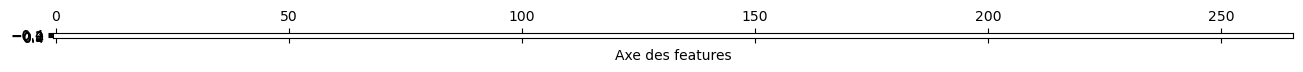

In [130]:
# Récupération du masque du sélecteur dans une variable mask.
mask = sel.get_support()

#Décommentez les lignes ci dessous avant d'exécuter votre code
plt.matshow(mask.reshape(1,-1), cmap = 'gray_r')
plt.xlabel('Axe des features');

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html#sklearn.feature_selection.f_classif

   Ne pas utiliser un test statistique de régression pour un problème de classification et inversement, les résultats n'auraient pas de sens !
   
   

Il existe plusieurs tests statistiques pour classer les variables les unes par rapport aux autres. Toutes ces méthodes sont regroupées sous le nom de Univariate Feature Selection. Dans le cas d’un problème supervisé, la dépendance entre la variable cible et les features est mesurée, 

The error message Input X must be non-negative says it all: Pearson's chi square test (goodness of fit) does not apply to negative values. It's logical because the chi square test assumes frequencies distribution and a frequency can't be a negative number. Consequently, sklearn.feature_selection.chi2 asserts the input is non-negative.

In [132]:
#X.shape

sel_Anova = SelectKBest(f_classif, k=25)

start_time = time.time()
# Ajustement de ce sélecteur sur le jeu d'entrainement.
sel_Anova.fit(X_train_encoded, y_train2)


X_new_Anova = sel_Anova.fit_transform(X_train_encoded, y_train2)
X_new_Anova.shape

(1833391, 25)

In [133]:
end_time = time.time()
execution_time = end_time - start_time
execution_time

53.37713003158569

In [134]:
X_new_Anova[:5,:]

array([[1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 1., 0.],
       [1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 1., 0., 0., 1., 0., 0., 0., 1.],
       [1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0.,
        0., 1., 0., 0., 0., 0., 1., 0., 1.],
       [1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 1., 0., 1.],
       [1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 1., 0.]])

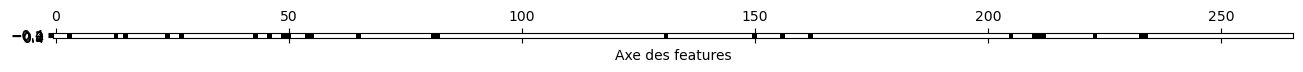

In [135]:
# Affichage de la représentation graphique des features sélectionnées.
mask = sel_Anova.get_support()
plt.matshow(mask.reshape(1,-1), cmap = 'gray_r')
plt.xlabel('Axe des features');

In [136]:
scores_Anova = -np.log10(sel_Anova.pvalues_)
scores_Anova /= scores_Anova.max()

/var/folders/g0/g76qn8pj0j10kx_v9q9r022w0000gn/T/ipykernel_17884/10897614.py:1: RuntimeWarning: divide by zero encountered in log10
  scores_Anova = -np.log10(sel_Anova.pvalues_)
/var/folders/g0/g76qn8pj0j10kx_v9q9r022w0000gn/T/ipykernel_17884/10897614.py:2: RuntimeWarning: invalid value encountered in true_divide
  scores_Anova /= scores_Anova.max()


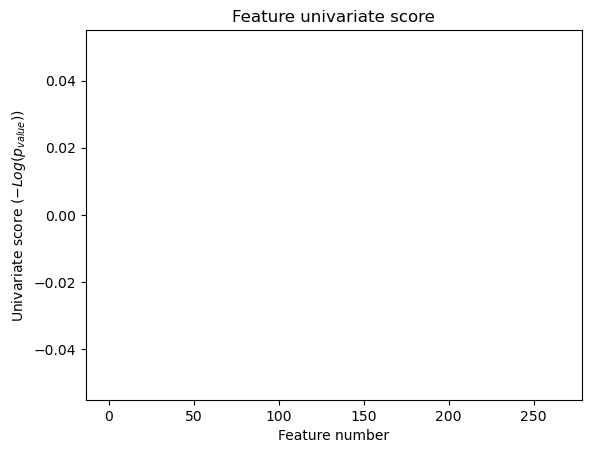

In [137]:
X_indices = np.arange(X_encoded.shape[-1])
plt.figure(1)
plt.clf()
plt.bar(X_indices, scores_Anova, width=0.2)
plt.title("Feature univariate score")
plt.xlabel("Feature number")
plt.ylabel(r"Univariate score ($-Log(p_{value})$)")
plt.show()

In [138]:
scores_Anova

array([ 0.,  0., nan, nan, nan, nan,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
       nan, nan, nan, nan, nan,  0., nan, nan, nan, nan, nan, nan,  0.,
       nan, nan, nan, nan, nan,  0., nan, nan,  0., nan, nan,  0.,  0.,
       nan, nan,  0., nan, nan, nan, nan, nan, nan, nan, nan, nan,  0.,
       nan, nan, nan, nan, nan,  0.,  0., nan,  0.,  0.,  0., nan,  0.,
       nan, nan, nan, nan,  0.,  0., nan, nan, nan, nan, nan, nan, nan,
       nan, nan,  0., nan, nan,  0.,  0.,  0.,  0., nan, nan,  0., nan,
        0.,  0.,  0.,  0., nan,  0.,  0., nan, nan, nan,  0., nan, nan,
       nan,  0., nan,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0., nan,  0.,  0., nan,  0., nan,  0.,  0.,  0.,  0.,  0., nan,
       nan,  0.,  0., nan,  0., nan, nan, nan,  0., nan,  0.,  0.,  0.,
       nan, nan, nan, nan,  0.,  0., nan, nan,  0., nan, nan,  0., nan,
       nan, nan, nan, nan, nan, nan, nan,  0.,  0.,  0., nan, na

In [139]:
sel_Anova.pvalues_

array([4.65071288e-102, 3.17831319e-159, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 5.08675756e-283, 6.86084775e-261,
       4.25074580e-200, 2.32243572e-006, 6.43186217e-011, 3.81043362e-023,
       8.40148858e-004, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 5.92741363e-111, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 6.82600129e-067, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 3.87186943e-215,
       0.00000000e+000, 0.00000000e+000, 5.04958796e-025, 0.00000000e+000,
       0.00000000e+000, 2.32589647e-089, 3.88765774e-055, 0.00000000e+000,
       0.00000000e+000, 1.88689437e-015, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 1.02213979e-008,
       0.00000000e+000, 0

In [140]:
sel_Anova.pvalues_.max()

0.6621410222754289

In [141]:
sel_mutual_info = SelectPercentile(mutual_info_classif, percentile=10)

# Ajustement de ce sélecteur sur le jeu d'entrainement.
start_time = time.time()
sel_mutual_info.fit(X_train_encoded, y_train2)

SelectPercentile(score_func=<function mutual_info_classif at 0x7fd657c03a60>)

In [142]:
end_time = time.time()
execution_time = end_time - start_time
execution_time

4674.870544910431

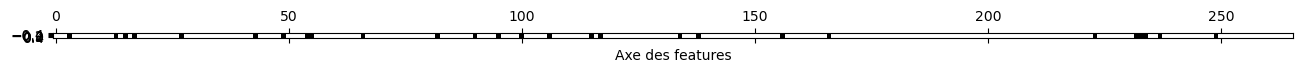

In [143]:
# Affichage de la représentation graphique des features sélectionnées.
mask = sel_mutual_info.get_support()
plt.matshow(mask.reshape(1,-1), cmap = 'gray_r')
plt.xlabel('Axe des features');

In [144]:
start_time = time.time()
X_new_mutual_info = sel_mutual_info.fit_transform(X_train_encoded, y_train2)
X_new_mutual_info.shape

(1833391, 27)

In [145]:
end_time = time.time()
execution_time = end_time - start_time
execution_time

4614.543684720993

##### La RFE (acronyme pour Recursive Feature Elimination). 

Le principe est simple : on fournit un modèle à l'algorithme RFE, qui est ajusté sur le jeu de données complet. L'importance de chaque feature est estimée et on supprime la ou les features les moins importantes, puis on recommence. Une fois le nombre de features cible atteint, on retourne le jeu de features qui a fourni le meilleur résultat sur le jeu d'entrainement.

Erreur
ValueError: when `importance_getter=='auto'`, the underlying estimator HistGradientBoostingClassifier should have `coef_` or `feature_importances_` attribute. Either pass a fitted estimator to feature selector or call fit before calling transform.

Explication 
To use RFE, it is a must to have a supervised learning estimator which attribute coef_ is available, this is the case of the linear kernel. The error you are getting is because coef_ is not for SVM using kernels different from Linear. It is in RFE documentation here = https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html


Utilisable avec : 

    - coef_
        - LogisticRegression, 
        - svm.SVC¶ (C-Support Vector Classification), 
        - svm.LinearSVC
        - RidgeClassifier
    - feature_importances_
        - AdaBoostClassifier
        - ExtraTreesClassifier
        - GradientBoostingClassifier
        - RandomForestClassifier
        - RandomTreesEmbedding
        
        
Pas utilisable avec : 

    - KNeighborsClassifier, HistGradientBoostingClassifier, ...

In [81]:
# Affecter à rfe une instance de RFE, qui utilise la régression comme estimateur via le classificateur Logistic Regression
rfe_logreg = RFE(estimator=logreg, step=1)#, n_features_to_select= half of the features are selected by default

# Ajustement du RFE sur le jeu d'entrainement.
rfe_logreg.fit(X_train_encoded, y_train2)

RFE(estimator=LogisticRegression(max_iter=2500, random_state=0))

In [82]:
logreg_ranking = rfe_logreg.ranking_.reshape(X_train_encoded.shape)

# Plot pixel ranking
plt.matshow(logreg_ranking, cmap=plt.cm.Blues)
plt.colorbar()
plt.title("Ranking of features with RFE")
plt.show()

ValueError: cannot reshape array of size 266 into shape (1833391,266)

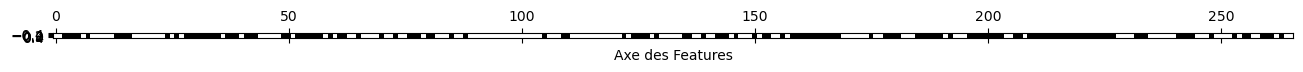

In [83]:
# Affichage de la représentation graphique des features sélectionnées
maskrfe_logreg = rfe_logreg.get_support()
plt.matshow(maskrfe_logreg.reshape(1,-1), cmap = 'gray_r')
plt.xlabel('Axe des Features');

In [84]:
rfe_logreg.support_

array([False, False,  True,  True,  True,  True, False,  True, False,
       False, False, False, False,  True,  True,  True,  True, False,
       False, False, False, False, False, False,  True, False,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True, False,  True,  True,  True, False,
       False, False, False, False,  True,  True, False,  True,  True,
        True,  True,  True,  True, False,  True, False,  True,  True,
       False, False,  True, False, False, False, False,  True, False,
       False,  True, False, False,  True,  True,  True, False,  True,
        True, False, False, False,  True, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False,  True, False,  True,  True,
        True,  True,

In [85]:
rfe_logreg.ranking_

array([134, 133,   1,   1,   1,   1,   2,   1,  24, 110, 111,  52,  13,
         1,   1,   1,   1, 129,  90,  53,  48,  98, 128, 105,   1,   6,
         1,  86,   1,   1,   1,   1,   1,   1,   1,   1,  21,   1,   1,
         1,  20,   1,   1,   1,  19,  15,  18,  44,  43,   1,   1,  65,
         1,   1,   1,   1,   1,   1,  85,   1,  59,   1,   1,  72,  12,
         1, 101,   9,  69,  37,   1,  71, 102,   1,  35,  47,   1,   1,
         1, 127,   1,   1,  32, 116,  22,   1,  23,  83,   1,  63,  45,
        64,  79,  33, 126, 113, 114,  93,  91,  89,  88,  92,  95,  96,
        49,   1,  97,  80,  70,   1,   1,  99,   3, 118,  66, 119,  55,
        61, 109,  60,  46, 107,   1, 108,   1,   1,   1,   1,  41,   1,
        67,   4,  39,   8,  40,   1,   1,  82, 100,   1, 122, 123,   1,
         1,   1,  30,   1,  68,  27, 124,   1,  26,   1,   1,  29,  38,
         1,  28,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
        42,  34,  94,  17, 103, 104,   1,  14,  16,   1,   1,   

In [87]:
X_train_encoded.columns[rfe_logreg.support_]

Index(['place_0.0', 'place_1.0', 'place_10.0', 'place_2.0', 'place_4.0',
       'catu_Conducteur', 'catu_Passager', 'catu_Piéton', 'sexe_Féminin',
       'trajet_Utilisation professionnelle',
       ...
       'int_Passage à niveau', 'int_Place', 'atm_Non renseigné',
       'atm_Temps éblouissant', 'col_Autre collision',
       'col_Deux véhicules - frontale', 'col_Non renseigné',
       'col_Sans collision',
       'col_Trois véhicules et plus - collisions multiples', 'age_acc_an'],
      dtype='object', length=133)

In [88]:
for col in X_train_encoded.columns[rfe_logreg.support_]:
    print(col)

place_0.0
place_1.0
place_10.0
place_2.0
place_4.0
catu_Conducteur
catu_Passager
catu_Piéton
sexe_Féminin
trajet_Utilisation professionnelle
locp_Non renseigné
locp_Sur accotement
locp_Sur chaussée-A + 50 m du passage piéton
locp_Sur chaussée-A – 50 m du passage piéton
locp_Sur contre allée
locp_Sur passage piéton-Avec signalisation lumineuse
locp_Sur passage piéton-Sans signalisation lumineuse
locp_Sur refuge ou BA
locp_Sur trottoir
actp_Avec animal
actp_Inconnue
actp_Jouant – courant
actp_Monte/descend du véhicule
actp_Non renseigné
actp_Non renseigné ou sans objet
etatp_Non renseigné
etatp_Seul
secuUn_Aucun équipement
secuUn_Autre
secuUn_Casque
secuUn_Ceinture
secuUn_Dispositif enfants
secuUn_Gants (2RM/3RM)
secuUn_Gilet réfléchissant
secuUn_Non renseigné
secuDeux_Airbag (2RM/3RM)(5)
secuDeux_Casque
secuDeux_Gilet réfléchissant(4)
tranches_ages_0-11
tranches_ages_32-40
tranches_ages_41-50
tranches_ages_50+
catr_2-Route nationale
catr_3-Route Départementale
catr_7-Routes de métropole

In [90]:
for col in X_train_encoded.columns[~rfe_logreg.support_]:
    print(col)

jour_de_la_semaine
heure
place_3.0
place_5.0
place_6.0
place_7.0
place_8.0
place_9.0
sexe_Masculin
trajet_Autre
trajet_Courses – achats
trajet_Domicile – travail
trajet_Domicile – école
trajet_Non renseigné
trajet_Promenade – loisirs
locp_Inconnue
locp_Sans objet
actp_Autre
actp_Masqué
actp_Sens inverse du véhicule
actp_Sens véhicule heurtant
actp_Traversant
etatp_Accompagné
etatp_En groupe
secuUn_Airbag (2RM/3RM)
secuUn_Gants + Airbag (2RM/3RM)
secuUn_Non déterminable
secuDeux_Aucun équipement
secuDeux_Autre
secuDeux_Ceinture
secuDeux_Dispositif enfants
secuDeux_Gants (2RM/3RM)(6)
secuDeux_Gants + Airbag (2RM/3RM)
secuDeux_Non déterminable
secuDeux_Non renseigné
tranches_ages_12-22
tranches_ages_23-31
catr_1-Autoroute
catr_4-Voie Communales
catr_5-Hors réseau public
catr_6-Parc de stationnement ouvert à la circulation publique
catr_9-Autres
circ_A chaussées séparées(3)
circ_Avec voies d’affectation variable(4)
circ_Bidirectionnelle(2)
circ_Non renseigné(-1)
vosp_Bande cyclable(2)
vosp

In [85]:
X_rfe = X_encoded[["place_0.0", "place_1.0", "place_10.0", "place_2.0", "place_4.0", "catu_Conducteur",
          "catu_Passager", "catu_Piéton", "sexe_Féminin", "trajet_Utilisation professionnelle",
          "locp_Non renseigné", "locp_Sur accotement", "locp_Sur chaussée-A + 50 m du passage piéton",
          "locp_Sur chaussée-A – 50 m du passage piéton", "locp_Sur contre allée", 
          "locp_Sur passage piéton-Avec signalisation lumineuse", "locp_Sur passage piéton-Sans signalisation lumineuse",
          "locp_Sur refuge ou BA", "locp_Sur trottoir", "actp_Avec animal", "actp_Inconnue", 
          "actp_Jouant – courant", "actp_Monte/descend du véhicule", "actp_Non renseigné", 
          "actp_Non renseigné ou sans objet", "etatp_Non renseigné", "etatp_Seul", "secuUn_Aucun équipement",
          "secuUn_Autre", "secuUn_Casque", "secuUn_Ceinture", "secuUn_Dispositif enfants", "secuUn_Gants (2RM/3RM)",
          "secuUn_Gilet réfléchissant", "secuUn_Non renseigné", "secuDeux_Airbag (2RM/3RM)(5)",
          "secuDeux_Casque", "secuDeux_Gilet réfléchissant(4)", "tranches_ages_0-11", "tranches_ages_32-40",
          "tranches_ages_41-50", "tranches_ages_50+", "catr_2-Route nationale", "catr_3-Route Départementale",
          "catr_7-Routes de métropole urbaine", "circ_A sens unique(1)", "plan_Non renseigné(-1)", 
          "surf_Corps gras – huile(8)", "surf_Enneigée(5)", "infra_Non renseigné", "infra_Souterrain - tunnel",
          "infra_Voie ferrée", "infra_Zone de péage", "infra_Zone piétonne", "situ_Autres(8)",
          "situ_Sur piste cyclable(5)", "situ_Sur trottoir(4)", "senc_Non renseigné", "obs_Autre glissière",
          "obs_Autre obstacle fixe sur chaussée", "obs_Autre obstacle fixe sur trottoir ou accotement",
          "obs_Buse – tête d’aqueduc", "obs_Glissière métallique", "obs_Mobilier urbain", "obs_Non renseigné",
          "obs_Sans objet", "obs_Support de signalisation verticale ou poste d’appel d’urgence",
          "obs_Véhicule en stationnement, Arbre", "obsm_Animal domestique", "obsm_Animal sauvage",
          "obsm_Aucun", "obsm_Autre", "obsm_Non renseigné", "obsm_Piéton", "obsm_Véhicule", "obsm_Véhicule sur rail",
          "choc_Arrière", "choc_Chocs multiples (tonneaux)", "choc_Non renseigné", "manv_A contresens",
          "manv_Arrêté (hors stationnement)", "manv_Autres manœuvres", "manv_Dans le couloir bus, dans le même sens",
          "manv_Dans le couloir bus, dans le sens inverse", "manv_Dépassant - A gauche", 
          "manv_Dépassant A droite", "manv_Déporté - A droite", "manv_Déporté - A gauche",
          "manv_En franchissant le terre-plein central", "manv_Entre 2 files", "manv_Inconnue",
          "manv_Manœuvre de stationnement", "manv_Manœuvre d’évitement", "manv_Même sens, même file",
          "manv_Non renseigné", "manv_Ouverture de porte", "manv_Sans changement de direction",
          "manv_Traversant la chaussée", "catv_Label_Autobus et autocars", "catv_Label_Bicyclette",
          "catv_Label_Deux ou trois roues de petite cylindrée (<= 50 cm3)",
          "catv_Label_Deux ou trois roues-motrices de grosse cylindrée (>125 cm3)",
          "catv_Label_Deux ou trois roues-motrices de moyenne cylindrée (50 à 125 cm3)",
          "catv_Label_Engins de déplacement personnels (EDP) sans moteur (ex : skateboards, roller, trottinette)",
          "catv_Label_Engins de déplacement personnels (EDP) à moteur (ex: trotinette)",
          "catv_Label_Indéterminable", "catv_Label_Poids lourds (PL) et camions", "catv_Label_Quad",
          "catv_Label_Tracteurs agricoles et engins spéciaux", "catv_Label_Tracteurs routiers",
          "catv_Label_Train", "catv_Label_Tramway", "catv_Label_Voitures légères (VL) avec carane ou remorque tractée",
          "catv_Label_Voitures légères (VL) seule", "catv_Label_Voiturette", "catv_Label_Véhicules utilitaires légers (VU)",
          "catv_Label_Véhicules utilitaires légers (VU) avec carane ou remorque tractée",
          "catv_Label_Vélo avec assistance électrique (VAE)", "lum_Plein jour", "agg_En agglomération",
          "agg_Hors agglomération", "int_Intersection à plus de 4 branches", "int_Non renseigné",
          "int_Passage à niveau", "int_Place", "atm_Non renseigné", "atm_Temps éblouissant", 
          "col_Autre collision", "col_Deux véhicules - frontale", "col_Non renseigné", 
          "col_Sans collision", "col_Trois véhicules et plus - collisions multiples", 
          "age_acc_an"]]

In [86]:
type(X_rfe)

pandas.core.frame.DataFrame

In [87]:
# split the array of features values, X, and target values, y, into training and test sets, 
#   ensuring that the same label proportions are reflected after the split
X_train_rfe, X_test_rfe, y_train_rfe, y_test_rfe = train_test_split(X_rfe, y, 
                                                                    test_size=0.2,
                                                                    stratify=y, 
                                                                    random_state=259)

In [125]:
# Création et entrainement modèles après reduction de dimenssion
result_accuracy = benchmarkClassifier(ridge_clf, "Ridge Classifier", X_train_rfe, y_train_rfe, 
                                      X_test_rfe, y_test_rfe)

print('training_time', 'test_time', 'train_score', 'test_score', 'ridge_accuracy_rfe', 'balanced_accuracy', 'geometric_mean_score')
print(result_accuracy[0], result_accuracy[1], result_accuracy[2], result_accuracy[3],result_accuracy[4],
     result_accuracy[5], result_accuracy[6])

Model: Ridge Classifier
---------------------------------------------------------------------------
Classification Report imbalanced :


/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                          pre       rec       spe        f1       geo       iba       sup

Blessé hospitalisé       0.53      0.27      0.94      0.36      0.51      0.24     93507
      Blessé léger       0.59      0.59      0.77      0.59      0.68      0.45    165057
           Indemne       0.67      0.88      0.70      0.76      0.78      0.62    187549
               Tué       0.00      0.00      1.00      0.00      0.00      0.00     12235

       avg / total       0.59      0.63      0.78      0.60      0.67      0.46    458348

---------------------------------------------------------------------------
Confusion Matrix:
[[ 25636  44872  22999      0]
 [ 11355  97218  56484      0]
 [  5001  18281 164267      0]
 [  6388   3123   2724      0]]
---------------------------------------------------------------------------
Balanced accuracy: 0.435 - Geometric mean: 0.000
---------------------------------------------------------------------------


/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 298, in _score
    y_pred = method_caller(clf, "predict_proba", X)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'RidgeClassifier' object has no attribute 'predict_proba'

  warnings.warn(
/opt/anaconda3/lib/python3.

Mean AUC Score: nan  temps execution en secondes :  199.88375997543335
training_time test_time train_score test_score ridge_accuracy_rfe balanced_accuracy geometric_mean_score
18.968169927597046 0.09815287590026855 62.634 62.643 62.643 0.435 0.0


In [126]:
result_accuracy = benchmarkClassifier(hist_gradient_boosting, "hist_gradient_boosting", 
                                      X_train_rfe, y_train_rfe, X_test_rfe, y_test_rfe)

print('training_time', 'test_time', 'train_score', 'test_score', 'hgbc_accuracy_rfe', 'balanced_accuracy', 'geometric_mean_score')
print(result_accuracy[0], result_accuracy[1], result_accuracy[2], result_accuracy[3],result_accuracy[4],
     result_accuracy[5], result_accuracy[6])

Model: hist_gradient_boosting
---------------------------------------------------------------------------
Classification Report imbalanced :
                          pre       rec       spe        f1       geo       iba       sup

Blessé hospitalisé       0.52      0.42      0.90      0.47      0.62      0.36     93507
      Blessé léger       0.62      0.62      0.78      0.62      0.70      0.48    165057
           Indemne       0.72      0.83      0.78      0.77      0.81      0.65    187549
               Tué       0.47      0.06      1.00      0.10      0.24      0.05     12235

       avg / total       0.64      0.65      0.81      0.64      0.71      0.51    458348

---------------------------------------------------------------------------
Confusion Matrix:
[[ 39299  38184  15380    644]
 [ 19819 102699  42405    134]
 [  8033  23685 155787     44]
 [  7784   2157   1579    715]]
---------------------------------------------------------------------------
Balanced accuracy: 0.

In [127]:
result_accuracy = benchmarkClassifier(logreg, "Logistic_Regression", X_train_rfe, 
                                      y_train_rfe, X_test_rfe, y_test_rfe)

print('training_time', 'test_time', 'train_score', 'test_score', 'logreg_accuracy_rfe', 'balanced_accuracy', 'geometric_mean_score')
print(result_accuracy[0], result_accuracy[1], result_accuracy[2], result_accuracy[3],result_accuracy[4],
     result_accuracy[5], result_accuracy[6])

Model: Logistic_Regression
---------------------------------------------------------------------------
Classification Report imbalanced :
                          pre       rec       spe        f1       geo       iba       sup

Blessé hospitalisé       0.52      0.37      0.91      0.43      0.58      0.32     93507
      Blessé léger       0.60      0.59      0.78      0.60      0.68      0.46    165057
           Indemne       0.70      0.85      0.75      0.76      0.79      0.64    187549
               Tué       0.43      0.04      1.00      0.07      0.19      0.03     12235

       avg / total       0.62      0.64      0.80      0.62      0.69      0.49    458348

---------------------------------------------------------------------------
Confusion Matrix:
[[ 34895  40326  17819    467]
 [ 17805  98060  49116     76]
 [  7160  21580 158770     39]
 [  7431   2458   1906    440]]
---------------------------------------------------------------------------
Balanced accuracy: 0.462

##### RFE with RIDGE ESTIMATOR

In [ ]:
# Affecter à rfe une instance de RFE, qui utilise la régression comme estimateur via le classificateur RIDGE
rfe_ridge = RFE(estimator=ridge_clf, step=1)#, n_features_to_select= half of the features are selected by default

# Ajustement du RFE sur le jeu d'entrainement.
rfe_ridge.fit(X_train_encoded, y_train2)

In [ ]:
ranking = rfe_ridge.ranking_.reshape(X_train_enc.shape)

# Plot pixel ranking
plt.matshow(ranking, cmap=plt.cm.Blues)
plt.colorbar()
plt.title("Ranking of pixels with RFE")
plt.show()

In [ ]:
# Affichage de la représentation graphique des features sélectionnées
maskrfe_ridge = rfe_ridge.get_support()
plt.matshow(maskrfe_ridge.reshape(1,-1), cmap = 'gray_r')
plt.xlabel('Axe des Features');

##### RFECV with LOGISTIC REGRESSION estimator

In [117]:
crossval = KFold(n_splits = 5, random_state = 2, shuffle = True)
#  Créer une instance de RFECV
rfecv = RFECV(estimator=logreg, cv=crossval)

start_time = time.time()
print("Start Time ",start_time)
#  Ajustement du modèle sur le jeu d'entrainement.
rfecv.fit(X_train_encoded, y_train2)
end_time = time.time()
execution_time = end_time - start_time
print("End Time ",execution_time)

Start Time  1695673345.574147
End Time  676335.740803957


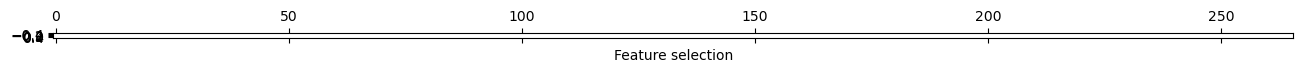

In [118]:
# (j) Affichage de la représentation graphique des features sélectionnées
maskrfecv = rfecv.get_support()
plt.matshow(maskrfecv.reshape(1,-1), cmap = 'gray_r')
plt.xlabel('Feature selection');

Nombre de features retenues : 266


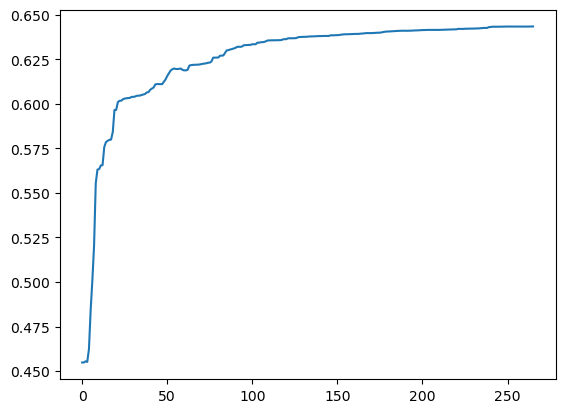

In [119]:
# (o) Courbe du score moyen en cross validation en fonction du nombre de features sélectionnées.
plt.plot(rfecv.cv_results_['mean_test_score']);

# (p) Affichage du nombre de features retenues.
print("Nombre de features retenues :", rfecv.n_features_)


In [146]:
rfecv.support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,